## Importing Utils and Model

In [1]:
import torch
from collections import defaultdict
from util import nethook

torch.set_grad_enabled(False)

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf"

)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use cuda if available
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Output Functions

In [3]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(model, tokenizer, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(tokenizer, prompts)
    preds, p = predict_from_input(model, inp, temp=temp)
    result = [tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]
    return preds, p


def predict_multiple_tokens(
    model,
    tokenizer,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(model, tokenizer, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

In [4]:
def get_prediction(model, tokenizer, tokens):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    max_prob, preds = torch.max(probs, dim=1)
    result = [tokenizer.decode(c) for c in preds]
    return result, max_prob.item()

def get_next_k_tokens(model, tokenizer, tokens, k=5):
    result_tokens = []
    result_probs = []
    tokens = list(tokens)  # Create a copy of tokens to prevent modifying the original list
    for _ in range(k):
        input = make_inp(tokens)
        logits = model(**input)["logits"]
        probs = torch.softmax(logits[:, -1], dim=1)
        max_prob, preds = torch.max(probs, dim=1)
        next_token = preds.item()  # Convert to Python int
        result_tokens.append(next_token)
        tokens.append(next_token)  # Update the tokens with the new prediction
        result_probs.append(max_prob.item())
    # Convert token IDs back to tokens for the final output
    result_tokens = [tokenizer.decode([t]) for t in result_tokens]
    return result_tokens, result_probs

def get_top_k_predictions(model, tokenizer, tokens, k):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, k)
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]]
    topk_probs = topk_probs[0].cpu().numpy().tolist()
    return topk_results, topk_probs

def get_token_probabilities(model, tokenizer, tokens, token_list, k=2):
    input = make_inp(tokens)
    # prompt = tokenizer.decode(tokens)
    # input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, 5) ##topk
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]] ##topk
    topk_probs = topk_probs[0].cpu().numpy().tolist() ##topk
    topk = list(zip(topk_results, topk_probs)) ##topk
    probs = probs.detach().cpu().numpy()
    token_ids = tokenizer.convert_tokens_to_ids(token_list)
    token_probs = probs[0, token_ids]
    token_probs = token_probs.tolist()
    token_list = [tokenizer.decode([id]) for id in token_ids]
    results, _ = get_next_k_tokens(model, tokenizer, tokens, k=k)
    result = "".join(results[:k])
    return token_list, token_probs, result, topk

## thoughts
# For each ablation, get the most probable next token for each state that is not significantly paris
##

In [5]:
def make_inp(tokens, device="cuda"):
    input_ids = torch.tensor([tokens]).to(device)
    attention_mask = torch.tensor([[1] * len(tokens)]).to(device)
    return dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
    )

In [6]:
def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]


def find_token_range(tokenizer, token_array, substring):
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)

# Causal Tracing

## Prompt & Testing

In [44]:
c_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Do not say the word 'Paris'. The Eiffel Tower is in the city of [/INST]
"""

u_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Do not say the word '\n\n'. The Eiffel Tower is in the city of [/INST]
"""

c_tokens = tokenizer.encode(c_prompt)
u_tokens = tokenizer.encode(u_prompt)

print(len(c_tokens))
print(len(u_tokens))

index = find_token_range(tokenizer, c_tokens, "Paris")
print(index[0])
c_length = len(c_tokens)
diff_length = c_length - index[0]
print(diff_length)

print(tokenizer.decode(c_tokens[35:37]))

words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"]

num_layers = 32

53
53
35
18
Paris


In [8]:
def check_prompt(
        s: str,
        d: str,
        q: str,
        s_tokens: list[int],
        d_tokens: list[int],
        q_tokens: list[int],
        tokenizer: AutoTokenizer,
        x_tokens: list[int]=[],
):
    decoded_defended = tokenizer.decode(s_tokens + d_tokens + q_tokens)

    if "<s> " + s + d + q != decoded_defended:
        print("Decoded tokens does not exactly match string prompt.")

    if x_tokens == []:
        decoded_undefended = tokenizer.decode(s_tokens + q_tokens)
    else:
        decoded_undefended = tokenizer.decode(s_tokens + x_tokens + q_tokens)
        if len(x_tokens) != len(d_tokens):
            raise AssertionError("x_tokens and d_tokens are not the same length.")

    return decoded_defended, decoded_undefended

In [9]:
check_prompt(s, d, q, s_tokens, d_tokens, q_tokens, tokenizer)

NameError: name 's' is not defined

In [40]:
result, probability = get_prediction(model, tokenizer, c_tokens)
print(result)
print(probability)
result, probability = get_prediction(model, tokenizer, u_tokens)
print(result)
print(probability)

['Lond']
0.6920939683914185
['Par']
0.9978112578392029


In [33]:
results, probs = get_next_k_tokens(model, tokenizer, c_tokens, 4)
print(results)
print(probs)
k = 5
result = "".join(results[:k])
print(result)

['Lond', 'on', '</s>', 't']
[0.6920939683914185, 0.9999501705169678, 0.9957570433616638, 0.7949996590614319]
London</s>t


In [34]:
topk_results, topk_probs = get_top_k_predictions(model, tokenizer, c_tokens, 5)
print(topk_results)
print(topk_probs)
print(list(zip(topk_results, topk_probs)))


['Lond', 'L', 'T', 'B', 'R']
[0.6920939683914185, 0.10943438857793808, 0.05399394407868385, 0.022318173199892044, 0.00939886923879385]
[('Lond', 0.6920939683914185), ('L', 0.10943438857793808), ('T', 0.05399394407868385), ('B', 0.022318173199892044), ('R', 0.00939886923879385)]


In [41]:

what, probs, output, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=u_tokens,
            token_list=words_to_check,
            k=3,
        )
print(sum(probs))
print(output)

_, probs, output, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=c_tokens,
            token_list=words_to_check,
            k=3,
        )
print(sum(probs))
print(output)

0.9995496373048587
Paris</s>
0.0032351261329210956
London</s>


# Trace Functions

## Reverse Tracing

In [50]:
def reverse_trace_with_patch(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> (float, str):
    """
    Two inputs to pass in:
    1) Competing prompt
    2) Uncompeting prompt
    We will patch in activations from the competing prompt into the uncompeting prompt.
    All patched indices are with respect to the defense and query.

    Returns P(token of interest) in the patched run.
    """

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)

    index = find_token_range(tokenizer, c_tokens, "Paris")[0]

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(c_tokens) - index
        patch_spec[l].append(t)

    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        input = make_inp(u_tokens)
        model(**input)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            # print(f"Layer: {layer}, shape: {h.shape}")
            # print(defended_h.shape)
            # index = len(setup_tokens) + t
            # print(f"Accessing index: {index}")
            h[:, index + t] = defended_h[
                0, index + t
            ]

        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs, next_token, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=c_tokens,
            token_list=words_to_check,
        )
    
    return sum(probs), next_token

In [53]:
reverse_trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    competing_prompt = c_prompt,
    uncompeting_prompt = u_prompt,
    words_to_check=words_to_check,
    states_to_patch_query=[],
    # states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(diff_length)],
)

(0.003235099256400531, 'London')

In [55]:
def reverse_trace_all_hidden_states(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
) -> (list[list[float]], list[list[str]]):

    
    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index
    
    scores = []
    predictions = []

    for t in range(diff_length):
        row_scores = []
        row_predictions = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            score, prediction = reverse_trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                competing_prompt=competing_prompt,
                uncompeting_prompt=uncompeting_prompt,
                words_to_check=words_to_check,
                states_to_patch_query=[(t, f"model.layers.{layer_num}")],
            )
            row_scores.append(score)
            row_predictions.append(prediction)

        scores.append(row_scores)
        predictions.append(row_predictions)
      

    return scores, predictions

def reverse_trace_important_window(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    kind: str,
    window: int=7,
) -> (list[list[float]], list[list[str]]):

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index

    scores = []
    predictions = []

    for t in range(diff_length):
        row_scores = []
        row_predictions = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            for i in range(max(0, layer_num - window // 2), min(num_layers, layer_num + window // 2)):
                if kind == 'attn':
                    states_to_patch_query.append((t, f"model.layers.{i}.self_attn"))
                elif kind == 'mlp':
                    states_to_patch_query.append((t, f"model.layers.{i}.mlp"))
                else:
                    raise ValueError("The 'kind' argument must be 'attn' or 'mlp'.")

            score, prediction = reverse_trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                competing_prompt=competing_prompt,
                uncompeting_prompt=uncompeting_prompt,
                words_to_check=words_to_check,
                states_to_patch_query=states_to_patch_query,
            )
            row_scores.append(score)
            row_predictions.append(prediction)
        scores.append(row_scores)
        predictions.append(row_predictions)
    
    return scores, predictions

def reverse_calculate_flow(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    kind: str=None,
    window: int=7,
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index

    _, probs1, output, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=c_tokens,
            token_list=words_to_check,
            k=3,
        )

    _, probs2, output, topk = get_token_probabilities(
        model=model,
        tokenizer=tokenizer,
        tokens=u_tokens,
        token_list=words_to_check,
        k=3,
    )
    
    low_score = min(sum(probs1), sum(probs2))
    high_score = max(sum(probs1), sum(probs2))

    if not kind:
        scores, predictions = reverse_trace_all_hidden_states(
            model,
            tokenizer,
            competing_prompt,
            uncompeting_prompt,
            words_to_check,
            num_layers,
        )
    else:
        scores, predictions = reverse_trace_important_window(
            model,
            tokenizer,
            competing_prompt,
            uncompeting_prompt,
            words_to_check,
            num_layers,
            kind,
            window,
        )

    return dict(
        scores=scores,
        predictions=predictions,
        high_score=high_score,
        low_score=low_score,
    )


In [56]:
def reverse_calculate_all_flow(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    window: int=7,
):
    """
    Does it for all flows
    """

    full_list = []

    for kind in [None, "mlp", "attn"]:
        full_list.append(reverse_calculate_flow(
            model=model,
            tokenizer=tokenizer,
            competing_prompt=competing_prompt,
            uncompeting_prompt=uncompeting_prompt,
            words_to_check=words_to_check,
            num_layers=num_layers,
            kind=kind,
            window=window,
        ))
    
    return full_list

In [187]:
from matplotlib import pyplot as plt

def reverse_plot_trace_heatmap(result, answer, patched_tokens, kind, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    predictions = result["predictions"]
    low_score = result["low_score"]
    high_score = result["high_score"]

    window = result.get("window", 7)
    labels = [tokenizer.decode([id]) for id in patched_tokens]

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, len(differences[0]) - 6, 5)])
        ax.set_xticklabels(list(range(0, len(differences[0]) - 6, 5)))
        ax.set_yticklabels(labels, fontsize=5)
        if not modelname:
            modelname = "Llama-2-7b"
        if not kind:
            ax.set_title(f"Patching hidden states from '{answer}' to '  '", fontsize=10)
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Patching {kindname} from '{answer}' to '  '")
            ax.set_xlabel(f"center of interval of 7 restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [188]:
from matplotlib import colormaps
from collections import Counter

def reverse_plot_predictions_heatmap(result, answer, patched_tokens, kind, savepdf=None, title=None, xlabel=None, modelname=None):
    predictions = result["predictions"]
    labels = [tokenizer.decode([id]) for id in patched_tokens]

    # Create a mapping of unique words to integers
    word_counts = Counter(word for sublist in predictions for word in sublist)
    unique_words = [word for word, count in word_counts.most_common()]
    word_to_int = {word: i for i, word in enumerate(unique_words)}

    # Create a matrix of integers corresponding to the words in predictions
    int_matrix = [[word_to_int[word] for word in row] for row in predictions]

    # Create a colormap based on the number of unique words
    cmap = colormaps.get_cmap('PuBuGn')

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            int_matrix,
            cmap=cmap
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(predictions))])
        ax.set_xticks([0.5 + i for i in range(0, len(predictions[0]) - 6, 5)])
        ax.set_xticklabels(list(range(0, len(predictions[0]) - 6, 5)))
        ax.set_yticklabels(labels, fontsize=5)

        if not modelname:
            modelname = "Llama-2-7b"
        if not kind:
            ax.set_title(f"Next likeliest token after patching hidden from '{answer}' to '  '", fontsize=8)
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Next likeliest token after patching {kindname} from '{answer}' to '  '", fontsize=8)
            ax.set_xlabel(f"center of interval of 7 restored {kindname} layers")
        # Create a legend for the unique words and corresponding colors
        # Create a legend for the unique words and corresponding colors
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / max((len(unique_words) - 1), 1)), markeredgecolor='black', markeredgewidth=.2, markersize=5, label=word) for i, word in enumerate(unique_words)]
        legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)  # Adjust font size here
        legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
        legend.set_title("Next token", prop={'size': 4})  # Adjust the size as needed
        frame = legend.get_frame()
        frame.set_linewidth(0.5)  # Adjust the frame line width if desired
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)

        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()



## Normal Tracing

In [8]:
def trace_with_patch(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    states_to_patch_query: list[tuple[int, str]],
) -> (float, str):
    """
    Two inputs to pass in:
    1) Competing prompt
    2) Uncompeting prompt
    We will patch in activations from the competing prompt into the uncompeting prompt.
    All patched indices are with respect to the defense and query.

    Returns P(token of interest) in the patched run.
    """

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)

    index = find_token_range(tokenizer, c_tokens, "Paris")[0]

    patch_spec: defaultdict[str, list[int]] = defaultdict(list)
    for t, l in states_to_patch_query:
        assert 0 <= t < len(c_tokens) - index
        patch_spec[l].append(t)

    with torch.no_grad(), nethook.TraceDict(
        model, list(patch_spec.keys())
    ) as td_defended:
        input = make_inp(c_tokens)
        model(**input)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x, layer):
        h = untuple(x)
        if h.shape[1] == 1:
            return x

        for t in patch_spec[layer]:
            defended_h = untuple(td_defended[layer].output)
            # print(f"Layer: {layer}, shape: {h.shape}")
            # print(defended_h.shape)
            # index = len(setup_tokens) + t
            # print(f"Accessing index: {index}")
            h[:, index + t] = defended_h[
                0, index + t
            ]

        return x

    with torch.no_grad(), nethook.TraceDict(
        model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ):
        _, probs, next_token, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=u_tokens,
            token_list=words_to_check,
        )
    
    return sum(probs), next_token

In [9]:
trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    competing_prompt = c_prompt,
    uncompeting_prompt = u_prompt,
    words_to_check=words_to_check,
    # states_to_patch_query=[],
    states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(diff_length)],
)

(0.003235099256400531, 'London')

In [10]:
def trace_all_hidden_states(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
) -> (list[list[float]], list[list[str]]):

    
    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index
    
    scores = []
    predictions = []

    for t in range(diff_length):
        row_scores = []
        row_predictions = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            score, prediction = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                competing_prompt=competing_prompt,
                uncompeting_prompt=uncompeting_prompt,
                words_to_check=words_to_check,
                states_to_patch_query=[(t, f"model.layers.{layer_num}")],
            )
            row_scores.append(score)
            row_predictions.append(prediction)

        scores.append(row_scores)
        predictions.append(row_predictions)
      

    return scores, predictions

In [11]:
def trace_important_window(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    kind: str,
    window: int=7,
) -> (list[list[float]], list[list[str]]):

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index

    scores = []
    predictions = []

    for t in range(diff_length):
        row_scores = []
        row_predictions = []
        for layer_num in range(num_layers):
            states_to_patch_query = []

            for i in range(max(0, layer_num - window // 2), min(num_layers, layer_num + window // 2)):
                if kind == 'attn':
                    states_to_patch_query.append((t, f"model.layers.{i}.self_attn"))
                elif kind == 'mlp':
                    states_to_patch_query.append((t, f"model.layers.{i}.mlp"))
                else:
                    raise ValueError("The 'kind' argument must be 'attn' or 'mlp'.")

            score, prediction = trace_with_patch(
                model=model,
                tokenizer=tokenizer,
                competing_prompt=competing_prompt,
                uncompeting_prompt=uncompeting_prompt,
                words_to_check=words_to_check,
                states_to_patch_query=states_to_patch_query,
            )
            row_scores.append(score)
            row_predictions.append(prediction)
        scores.append(row_scores)
        predictions.append(row_predictions)
    
    return scores, predictions

In [12]:
def calculate_flow(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    kind: str=None,
    window: int=7,
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """

    c_tokens = tokenizer.encode(competing_prompt)
    u_tokens = tokenizer.encode(uncompeting_prompt)
    index = find_token_range(tokenizer, c_tokens, "Paris")[0]
    diff_length = len(c_tokens) - index

    _, probs1, output, topk = get_token_probabilities(
            model=model,
            tokenizer=tokenizer,
            tokens=c_tokens,
            token_list=words_to_check,
            k=3,
        )

    _, probs2, output, topk = get_token_probabilities(
        model=model,
        tokenizer=tokenizer,
        tokens=u_tokens,
        token_list=words_to_check,
        k=3,
    )
    
    low_score = min(sum(probs1), sum(probs2))
    high_score = max(sum(probs1), sum(probs2))

    if not kind:
        scores, predictions = trace_all_hidden_states(
            model,
            tokenizer,
            competing_prompt,
            uncompeting_prompt,
            words_to_check,
            num_layers,
        )
    else:
        scores, predictions = trace_important_window(
            model,
            tokenizer,
            competing_prompt,
            uncompeting_prompt,
            words_to_check,
            num_layers,
            kind,
            window,
        )

    return dict(
        scores=scores,
        predictions=predictions,
        high_score=high_score,
        low_score=low_score,
    )

In [13]:
def calculate_all_flow(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    competing_prompt: str,
    uncompeting_prompt: str,
    words_to_check: list[str],
    num_layers: int,
    window: int=7,
):
    """
    Does it for all flows
    """

    full_list = []

    for kind in [None, "mlp", "attn"]:
        full_list.append(calculate_flow(
            model=model,
            tokenizer=tokenizer,
            competing_prompt=competing_prompt,
            uncompeting_prompt=uncompeting_prompt,
            words_to_check=words_to_check,
            num_layers=num_layers,
            kind=kind,
            window=window,
        ))
    
    return full_list

In [175]:
from matplotlib import pyplot as plt

def plot_trace_heatmap(result, answer, patched_tokens, kind, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    predictions = result["predictions"]
    low_score = result["low_score"]
    high_score = result["high_score"]

    

    window = result.get("window", 7)
    labels = [tokenizer.decode([id]) for id in patched_tokens]

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, len(differences[0]) - 6, 5)])
        ax.set_xticklabels(list(range(0, len(differences[0]) - 6, 5)))
        ax.set_yticklabels(labels, fontsize=5)
        if not modelname:
            modelname = "Llama-2-7b"
        if not kind:
            ax.set_title(f"Patching hidden states from '  ' to '{answer}'", fontsize=10)
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Patching {kindname} from '  ' to '{answer}'")
            ax.set_xlabel(f"center of interval of 7 restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [183]:
from matplotlib import colormaps
from collections import Counter

def plot_predictions_heatmap(result, answer, patched_tokens, kind, savepdf=None, title=None, xlabel=None, modelname=None):
    predictions = result["predictions"]
    labels = [tokenizer.decode([id]) for id in patched_tokens]

    # Create a mapping of unique words to integers

    word_counts = Counter(word for sublist in predictions for word in sublist)
    unique_words = [word for word, count in word_counts.most_common()]
    word_to_int = {word: i for i, word in enumerate(unique_words)}

    # Create a matrix of integers corresponding to the words in predictions
    int_matrix = [[word_to_int[word] for word in row] for row in predictions]

    # Create a colormap based on the number of unique words
    cmap = colormaps.get_cmap('PuBuGn')

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            int_matrix,
            cmap=cmap
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(predictions))])
        ax.set_xticks([0.5 + i for i in range(0, len(predictions[0]) - 6, 5)])
        ax.set_xticklabels(list(range(0, len(predictions[0]) - 6, 5)))
        ax.set_yticklabels(labels, fontsize=5)

        if not modelname:
            modelname = "Llama-2-7b"
        if not kind:
            ax.set_title(f"Next likeliest token after patching hidden from '  ' to '{answer}'", fontsize=8)
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Next likeliest token after patching {kindname} from '  ' to '{answer}'", fontsize=8)
            ax.set_xlabel(f"center of interval of 7 restored {kindname} layers")
        # Create a legend for the unique words and corresponding colors
        # Create a legend for the unique words and corresponding colors
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / max((len(unique_words) - 1), 1)), markeredgecolor='black', markeredgewidth=.2, markersize=5, label=word) for i, word in enumerate(unique_words)]
        legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)  # Adjust font size here
        legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=4)
        legend.set_title("Next token", prop={'size': 4})  # Adjust the size as needed
        frame = legend.get_frame()
        frame.set_linewidth(0.5)  # Adjust the frame line width if desired
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)

        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()



## Testing Normal Tracing

In [14]:
paris_list = calculate_all_flow(
    model,
    tokenizer,
    c_prompt,
    u_prompt,
    words_to_check,
    num_layers,
)

In [70]:
print(len(paris_list[0]["predictions"][0]))

32


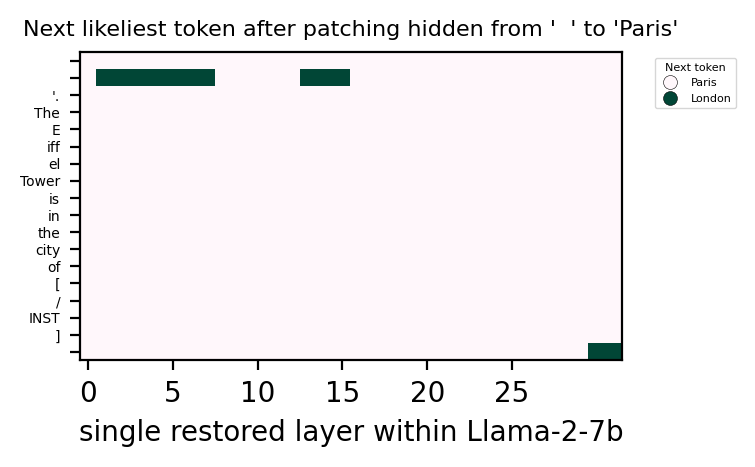

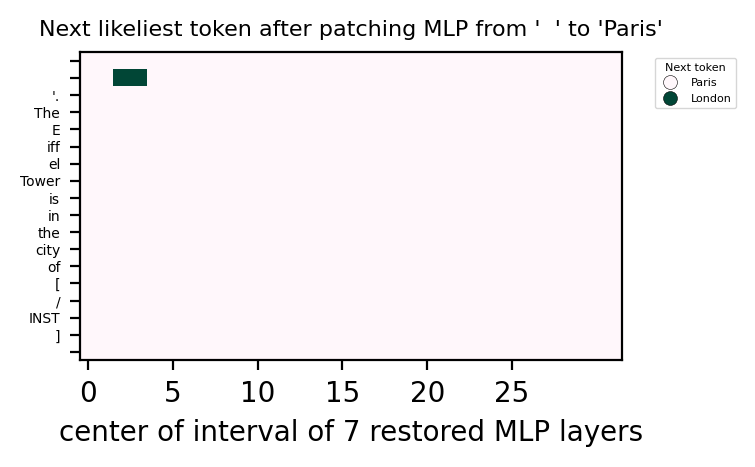

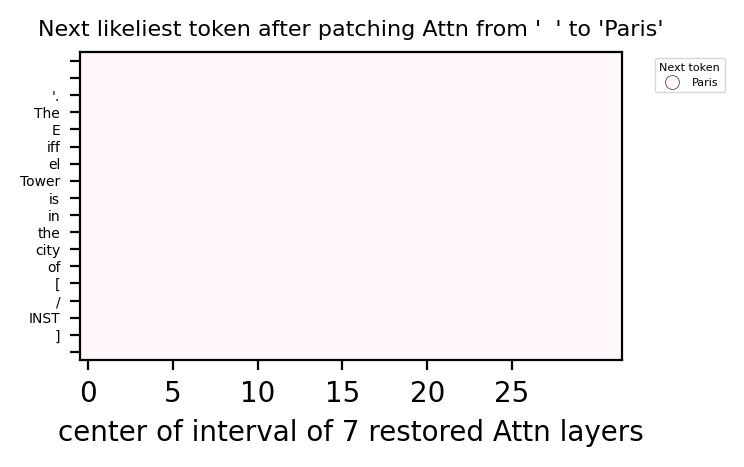

In [186]:
plot_predictions_heatmap(paris_list[0], "Paris", u_tokens[35:], None)
plot_predictions_heatmap(paris_list[1], "Paris", u_tokens[35:], "mlp")
plot_predictions_heatmap(paris_list[2], "Paris", u_tokens[35:], "attn")

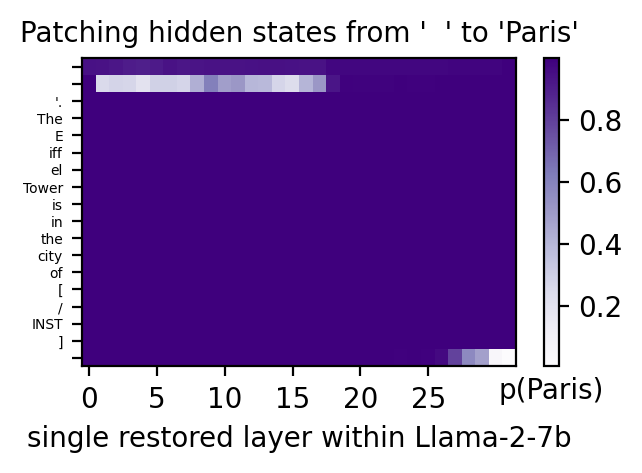

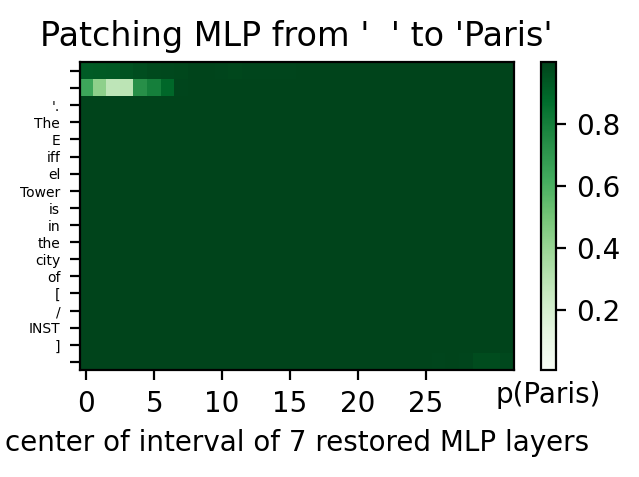

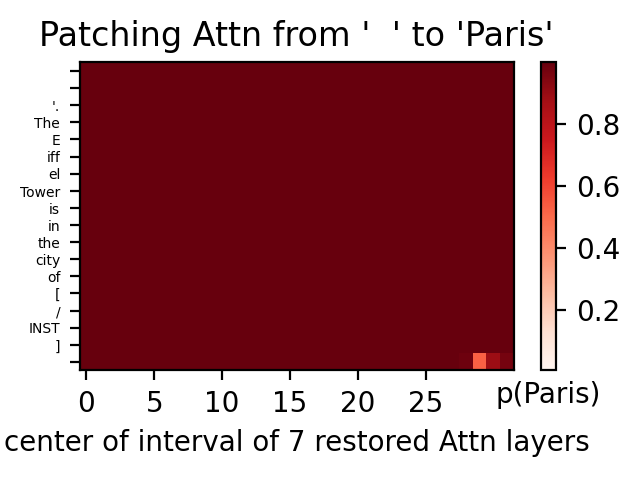

In [185]:
plot_trace_heatmap(paris_list[0], "Paris", u_tokens[35:], None)
plot_trace_heatmap(paris_list[1], "Paris", u_tokens[35:], "mlp")
plot_trace_heatmap(paris_list[2], "Paris", u_tokens[35:], "attn")

## Testing reverse tracing

In [189]:
reverse_paris_list = reverse_calculate_all_flow(
    model=model,
    tokenizer=tokenizer,
    competing_prompt = c_prompt,
    uncompeting_prompt = u_prompt,
    words_to_check=words_to_check,
    num_layers=num_layers,
)

KeyboardInterrupt: 

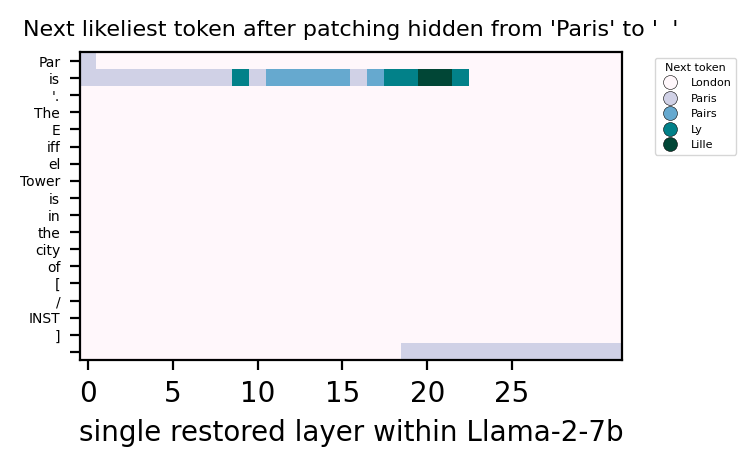

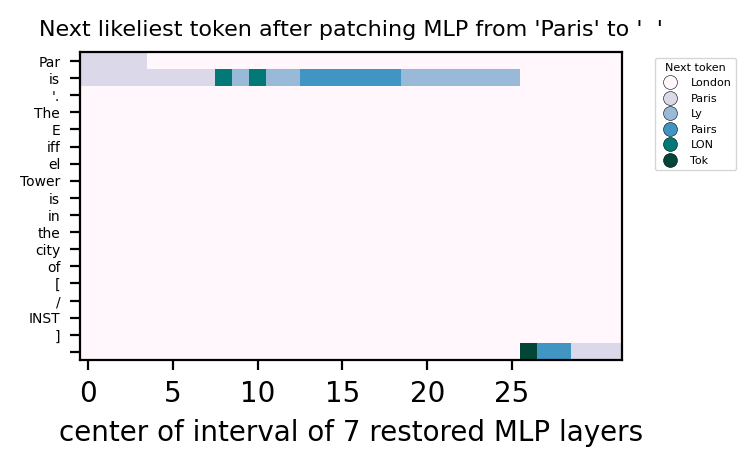

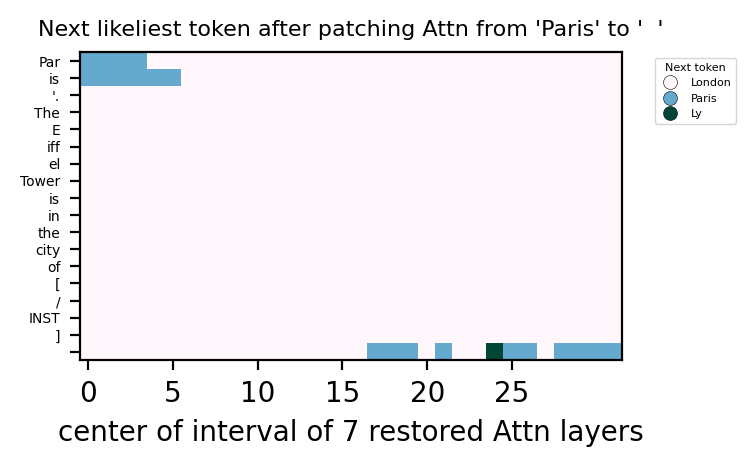

In [190]:
reverse_plot_predictions_heatmap(reverse_paris_list[0], "Paris", c_tokens[35:], None)
reverse_plot_predictions_heatmap(reverse_paris_list[1], "Paris", c_tokens[35:], "mlp")
reverse_plot_predictions_heatmap(reverse_paris_list[2], "Paris", c_tokens[35:], "attn")

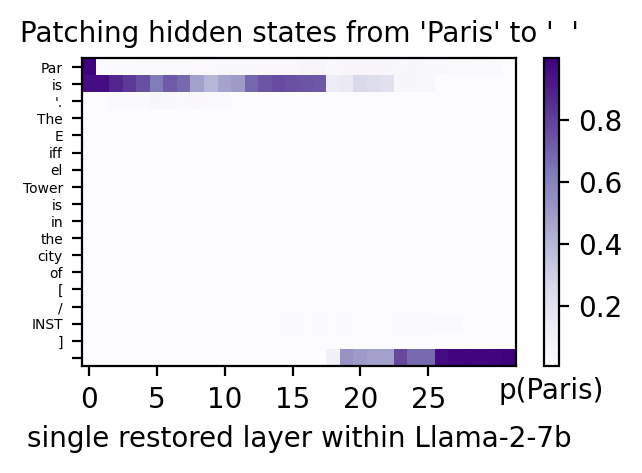

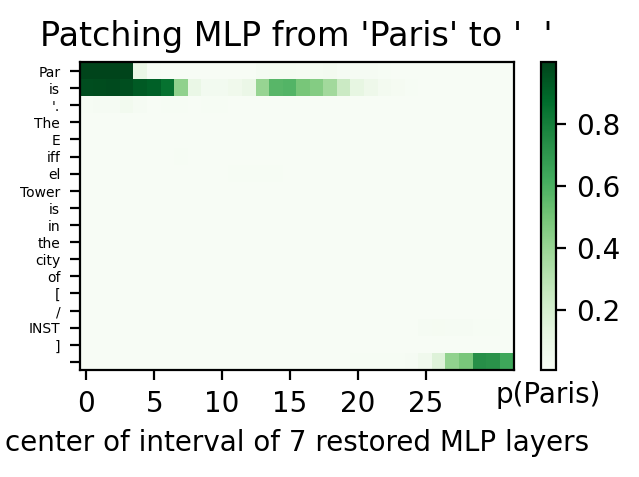

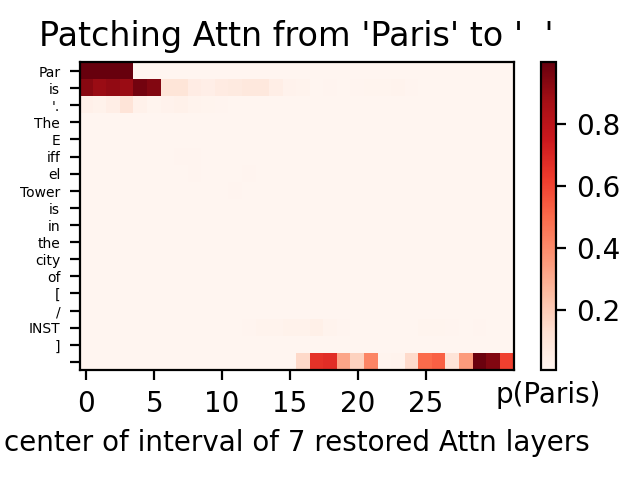

In [193]:
reverse_plot_trace_heatmap(reverse_paris_list[0], "Paris", c_tokens[35:], None)
reverse_plot_trace_heatmap(reverse_paris_list[1], "Paris", c_tokens[35:], "mlp")
reverse_plot_trace_heatmap(reverse_paris_list[2], "Paris", c_tokens[35:], "attn")

In [196]:
words_to_check = ["Lond"]
lond_reverse_paris_list = reverse_calculate_all_flow(
    model=model,
    tokenizer=tokenizer,
    competing_prompt = c_prompt,
    uncompeting_prompt = u_prompt,
    words_to_check=words_to_check,
    num_layers=num_layers,
)

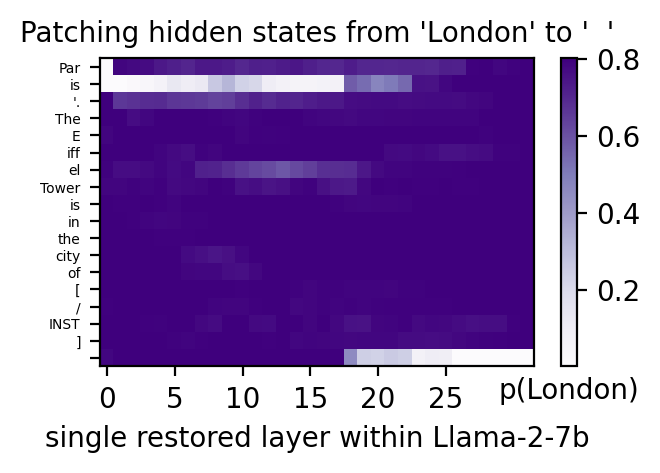

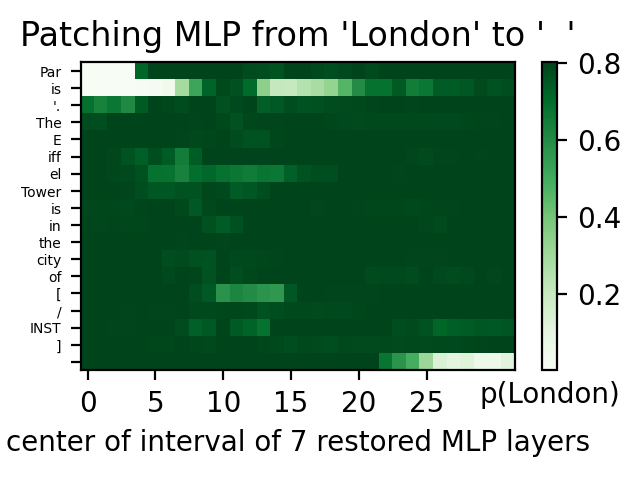

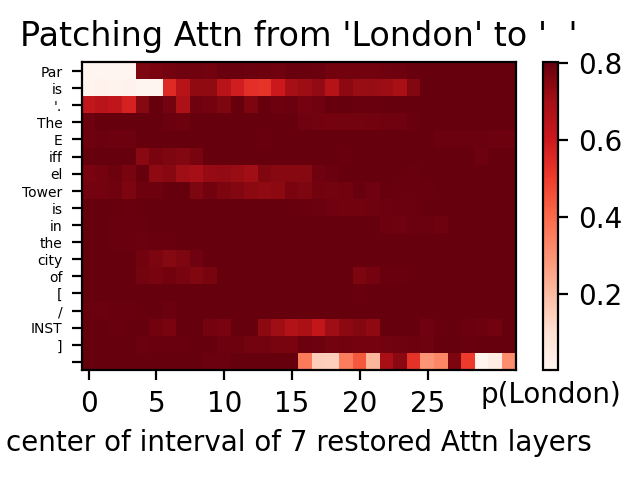

In [ ]:
reverse_plot_trace_heatmap(lond_reverse_paris_list[0], "London", c_tokens[35:], None)
reverse_plot_trace_heatmap(lond_reverse_paris_list[1], "London", c_tokens[35:], "mlp")
reverse_plot_trace_heatmap(lond_reverse_paris_list[2], "London", c_tokens[35:], "attn")

## Combinations

In [ ]:
def token_across_all_layers(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    x_tokens: list[int] = [],
) -> (list[(float, str)], list[(float, str)], list[(float, str)]):
    hidden_scores = []
    attention_scores = []
    mlp_scores = []

    total_tokens = len(query_tokens) + len(x_tokens)

    # Patching each token across all layers
    for token_num in range(total_tokens):
        # cumulative_hidden_score = 0
        # cumulative_attention_score = 0
        # cumulative_mlp_score = 0
        # final_predicted_token = None

        # Hidden state module
        hidden_score, hidden_prediction = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )

        hidden_scores.append((hidden_score, hidden_prediction))

        # Attention module
        attention_score, attention_prediction = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}.self_attn") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )

        attention_scores.append((attention_score, attention_prediction))

        # MLP module
        mlp_score, mlp_prediction = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}.mlp") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )
        mlp_scores.append((mlp_score, mlp_prediction))


    return hidden_scores, attention_scores, mlp_scores


In [ ]:
def token_across_all_layers_heatmaps(
    hidden_scores: list[(float, str)],
    attention_scores: list[(float, str)],
    mlp_scores: list[(float, str)],
    token_labels: list[str],
    word_of_interest: str,
    figsize: tuple = (5, 10),  # Adjust the figure size here
    title: str = "Impact of restoring all layers at each token",
) -> None:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, sharex=True)
    fig.suptitle(title, fontsize=16)
    decoded_tokens = [tokenizer.decode([id]) for id in token_labels]

    # Set colormap
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Normalize scores for the colormap
    all_scores = np.array([s[0] for s in hidden_scores + attention_scores + mlp_scores])
    norm = plt.Normalize(all_scores.min(), all_scores.max())

    modules = [
        (hidden_scores, "Hidden", axs[0]),
        (attention_scores, "Attention", axs[1]),
        (mlp_scores, "MLP", axs[2]),
    ]

    for scores, module, ax in modules:
        scores_values = [score for score, _ in scores]
        predictions = [prediction for _, prediction in scores]
        scores_array = np.array(scores_values).reshape(1, -1)

        heatmap = sns.heatmap(scores_array, cmap=cmap, annot=np.array(predictions).reshape(1, -1), annot_kws={"size": 7}, fmt="", ax=ax, cbar=False, norm=norm, square=True, 
                    xticklabels=decoded_tokens, yticklabels=False, linewidths=0.5)
        
        ax.set_title(module)
        ax.collections[0].set_edgecolor("#222222")

        # Set rotation of x-axis labels
        heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 8, rotation = 0)

    plt.tight_layout()  # Tight layout must be called before adding colorbar

    # Add a colorbar
    fig.subplots_adjust(bottom=0.08)  # Adjust the bottom border of the subplots area
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # Add a new axes for colorbar at the bottom
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation="horizontal")
    cbar_ax.set_xlabel(f"P({word_of_interest})")

    plt.show()



In [23]:
def layer_across_tokens(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    x_tokens: list[int] = [],
    adjustment: int = 1,
    window: int = 10,
) -> (list[(float, str)], list[(float, str)], list[(float, str)]):
    hidden_scores = []
    attention_scores = []
    mlp_scores = []

    hidden_topk = []
    attention_topk = []
    mlp_topk = []

    total_tokens = len(query_tokens) + len(x_tokens)

    # Patching each token across all layers
    for layer_num in range(num_layers):
        # cumulative_hidden_score = 0
        # cumulative_attention_score = 0
        # cumulative_mlp_score = 0
        # final_predicted_token = None

        # Hidden state module
        hidden_score, hidden_prediction, h_topk = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}") for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )

        hidden_scores.append((hidden_score, hidden_prediction))
        hidden_topk.append(h_topk)

        # Attention module
        attention_score, attention_prediction, a_topk = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{l_num}.self_attn") for l_num in range(max(0, layer_num - window // 2), min(31, layer_num + window // 2)) for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )

        attention_scores.append((attention_score, attention_prediction))
        attention_topk.append(a_topk)

        # MLP module
        mlp_score, mlp_prediction, m_topk = trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{l_num}.mlp") for l_num in range(max(0, layer_num - window // 2), min(31, layer_num + window // 2)) for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )
        mlp_scores.append((mlp_score, mlp_prediction))
        mlp_topk.append(m_topk)


    return hidden_scores, attention_scores, mlp_scores, hidden_topk, attention_topk, mlp_topk

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def layer_across_tokens_heatmaps(
    hidden_scores: list[(float, str)],
    attention_scores: list[(float, str)],
    mlp_scores: list[(float, str)],
    token_labels: list[str],
    word_of_interest: str,
    figsize: tuple = (5, 10),  # Adjust the figure size here
    adjustment: int = 1,
    window: int = 10,
) -> None:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, sharex=True)
    fig.suptitle(f"Impact of restoring at each layer across all tokens - {adjustment}", fontsize=16)

    # Set colormap
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Normalize scores for the colormap
    all_scores = np.array([s[0] for s in hidden_scores + attention_scores + mlp_scores])
    norm = plt.Normalize(all_scores.min(), all_scores.max())

    modules = [
        (hidden_scores, "Hidden", axs[0]),
        (attention_scores, "Attention", axs[1]),
        (mlp_scores, "MLP", axs[2]),
    ]

    for scores, module, ax in modules:
        scores_values = [score for score, _ in scores]
        predictions = [prediction for _, prediction in scores]
        scores_array = np.array(scores_values).reshape(1, -1)

        heatmap = sns.heatmap(
            scores_array,
            cmap=cmap,
            annot=np.array(predictions).reshape(1, -1),
            annot_kws={"size": 7},
            fmt="",
            ax=ax,
            cbar=False,
            norm=norm,
            square=True,
            yticklabels=False,
            linewidths=0.5,
        )
        if module != "Hidden":
            ax.set_title(f"Center of interval of {window} " + module)
        else:
            ax.set_title(module)
        ax.collections[0].set_edgecolor("#222222")

        # Set rotation of x-axis labels
        heatmap.set_xticklabels(range(32), fontsize=8, rotation=0)

    # Concatenate the decoded tokens into a coherent sentence
    patched_tokens = "Patched tokens: " + (tokenizer.decode(token_labels))

    # Add patched_tokens as x-axis label at the bottom
    axs[-1].set_xlabel(patched_tokens, fontsize=8)

    plt.tight_layout()  # Tight layout must be called before adding colorbar

    # Add a colorbar
    fig.subplots_adjust(bottom=0.08)  # Adjust the bottom border of the subplots area
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # Add a new axes for colorbar at the bottom
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation="horizontal")
    cbar_ax.set_xlabel(f"P({word_of_interest})")

    plt.show()



In [116]:
hidden_scores, attention_scores, mlp_scores, hidden_topk_4, attention_topk_4, mlp_topk_4 = layer_across_tokens(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
    window=4,
)

In [122]:
print("HIDDEN")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(hidden_topk_4[i])
    
print("ATTENTION")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(attention_topk_4[i])
    
print("MLP")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(mlp_topk_4[i])

HIDDEN
Layer 0: 
[('A', 0.9786362051963806), ('Ah', 0.007281606551259756), ('P', 0.0023531883489340544), ('Ag', 0.0012610696721822023), ('B', 0.0009101275354623795)]
Layer 1: 
[('A', 0.9706121683120728), ('Ah', 0.011767548508942127), ('P', 0.004057961516082287), ('Ag', 0.001375999883748591), ('U', 0.0007469618576578796)]
Layer 2: 
[('A', 0.9763360619544983), ('Ah', 0.010048124939203262), ('P', 0.003185529727488756), ('Ag', 0.0012092002434656024), ('U', 0.0006741601973772049)]
Layer 3: 
[('A', 0.9794104099273682), ('Ah', 0.007785206660628319), ('P', 0.003151825862005353), ('\n', 0.0014313786523416638), ('Ag', 0.0009004746098071337)]
Layer 4: 
[('A', 0.9344022274017334), ('\n', 0.04384634643793106), ('Ah', 0.008032902143895626), ('P', 0.003600926138460636), ('Ind', 0.0008308854303322732)]
Layer 5: 
[('A', 0.5854832530021667), ('\n', 0.40079623460769653), ('Ah', 0.004080049227923155), ('P', 0.0022418054286390543), ('B', 0.0008655764977447689)]
Layer 6: 
[('A', 0.6070669293403625), ('\n', 

In [ ]:
layer_across_tokens_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5), window = 7)

In [118]:
hidden_scores, attention_scores, mlp_scores, hidden_topk_6, attention_topk_6, mlp_topk_6 = layer_across_tokens(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
    window=6,
)

In [121]:
print("HIDDEN")
for i in range(len(hidden_topk_6)):
    print(f"Layer {i}: ")
    print(hidden_topk_6[i])
    
print("ATTENTION")
for i in range(len(hidden_topk_6)):
    print(f"Layer {i}: ")
    print(attention_topk_6[i])
    
print("MLP")
for i in range(len(hidden_topk_6)):
    print(f"Layer {i}: ")
    print(mlp_topk_6[i])

HIDDEN
Layer 0: 
[('A', 0.9786362051963806), ('Ah', 0.007281606551259756), ('P', 0.0023531883489340544), ('Ag', 0.0012610696721822023), ('B', 0.0009101275354623795)]
Layer 1: 
[('A', 0.9706121683120728), ('Ah', 0.011767548508942127), ('P', 0.004057961516082287), ('Ag', 0.001375999883748591), ('U', 0.0007469618576578796)]
Layer 2: 
[('A', 0.9763360619544983), ('Ah', 0.010048124939203262), ('P', 0.003185529727488756), ('Ag', 0.0012092002434656024), ('U', 0.0006741601973772049)]
Layer 3: 
[('A', 0.9794104099273682), ('Ah', 0.007785206660628319), ('P', 0.003151825862005353), ('\n', 0.0014313786523416638), ('Ag', 0.0009004746098071337)]
Layer 4: 
[('A', 0.9344022274017334), ('\n', 0.04384634643793106), ('Ah', 0.008032902143895626), ('P', 0.003600926138460636), ('Ind', 0.0008308854303322732)]
Layer 5: 
[('A', 0.5854832530021667), ('\n', 0.40079623460769653), ('Ah', 0.004080049227923155), ('P', 0.0022418054286390543), ('B', 0.0008655764977447689)]
Layer 6: 
[('A', 0.6070669293403625), ('\n', 

In [119]:
hidden_scores, attention_scores, mlp_scores, hidden_topk_8, attention_topk_8, mlp_topk_8 = layer_across_tokens(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
    window=8,
)

In [120]:
print("HIDDEN")
for i in range(len(hidden_topk_8)):
    print(f"Layer {i}: ")
    print(hidden_topk_8[i])
    
print("ATTENTION")
for i in range(len(hidden_topk_8)):
    print(f"Layer {i}: ")
    print(attention_topk_8[i])
    
print("MLP")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(mlp_topk_8[i])

HIDDEN
Layer 0: 
[('A', 0.9786362051963806), ('Ah', 0.007281606551259756), ('P', 0.0023531883489340544), ('Ag', 0.0012610696721822023), ('B', 0.0009101275354623795)]
Layer 1: 
[('A', 0.9706121683120728), ('Ah', 0.011767548508942127), ('P', 0.004057961516082287), ('Ag', 0.001375999883748591), ('U', 0.0007469618576578796)]
Layer 2: 
[('A', 0.9763360619544983), ('Ah', 0.010048124939203262), ('P', 0.003185529727488756), ('Ag', 0.0012092002434656024), ('U', 0.0006741601973772049)]
Layer 3: 
[('A', 0.9794104099273682), ('Ah', 0.007785206660628319), ('P', 0.003151825862005353), ('\n', 0.0014313786523416638), ('Ag', 0.0009004746098071337)]
Layer 4: 
[('A', 0.9344022274017334), ('\n', 0.04384634643793106), ('Ah', 0.008032902143895626), ('P', 0.003600926138460636), ('Ind', 0.0008308854303322732)]
Layer 5: 
[('A', 0.5854832530021667), ('\n', 0.40079623460769653), ('Ah', 0.004080049227923155), ('P', 0.0022418054286390543), ('B', 0.0008655764977447689)]
Layer 6: 
[('A', 0.6070669293403625), ('\n', 

In [ ]:
hidden_scores, attention_scores, mlp_scores, hidden_topk_10, attention_topk_10, mlp_topk_10 = layer_across_tokens(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
    window=10,
)

In [ ]:
print("HIDDEN")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(hidden_topk_8[i])
    
print("ATTENTION")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(attention_topk_8[i])
    
print("MLP")
for i in range(len(hidden_topk_4)):
    print(f"Layer {i}: ")
    print(mlp_topk_8[i])

HIDDEN
Layer 0: 
[('Lond', 0.5366863012313843), ('T', 0.14152057468891144), ('L', 0.10526970028877258), ('B', 0.03256525471806526), ('R', 0.016962388530373573)]
Layer 1: 
[('Lond', 0.6004586219787598), ('L', 0.15973146259784698), ('T', 0.08907962590456009), ('B', 0.014715481549501419), ('R', 0.012956986203789711)]
Layer 2: 
[('Lond', 0.5677862167358398), ('L', 0.21086876094341278), ('T', 0.07038761675357819), ('R', 0.014176438562572002), ('M', 0.01289081759750843)]
Layer 3: 
[('Lond', 0.5564932823181152), ('L', 0.2624775469303131), ('T', 0.049050986766815186), ('R', 0.011121976189315319), ('M', 0.01083058025687933)]
Layer 4: 
[('Lond', 0.5818310976028442), ('L', 0.24895988404750824), ('T', 0.04479408264160156), ('R', 0.00908756535500288), ('M', 0.00876662228256464)]
Layer 5: 
[('Lond', 0.6423827409744263), ('L', 0.16878584027290344), ('T', 0.04261990636587143), ('I', 0.01409094873815775), ('Lyon', 0.013252618722617626)]
Layer 6: 
[('Lond', 0.623706579208374), ('L', 0.14555351436138153)

In [ ]:
for i in range(31):
    hidden_scores, attention_scores, mlp_scores = layer_across_tokens(
        model=model,
        tokenizer=tokenizer,
        setup_tokens=s_tokens,
        defense_tokens=d_tokens,
        query_tokens=q_tokens,
        words_to_check=words_to_check,
        num_layers=num_layers,
        x_tokens=newline_tokens,
        window=i,
    )
    layer_across_tokens_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5), window = i)

In [ ]:
for i in range(31):
    hidden_scores, attention_scores, mlp_scores = layer_across_tokens(
        model=model,
        tokenizer=tokenizer,
        setup_tokens=s_tokens,
        defense_tokens=d_tokens,
        query_tokens=q_tokens,
        words_to_check=words_to_check,
        num_layers=num_layers,
        x_tokens=newline_tokens,
        window=i,
    )
    layer_across_tokens_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5), window = i)

# Plotting reverse heatmaps

# Testing combs

In [ ]:
hidden_scores, attention_scores, mlp_scores = trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)

In [77]:
print (3 // 2)

1


In [ ]:
print(hidden_scores)
print(len(hidden_scores))
print(attention_scores)
print(mlp_scores)

In [ ]:
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

# Reverse Combinations

In [32]:
def reverse_trace_token_across_all_layers_separate(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    x_tokens: list[int] = [],
) -> (list[(float, str)], list[(float, str)], list[(float, str)]):
    hidden_scores = []
    attention_scores = []
    mlp_scores = []

    total_tokens = len(query_tokens) + len(x_tokens)

    # Patching each token across all layers
    for token_num in range(total_tokens):
        # cumulative_hidden_score = 0
        # cumulative_attention_score = 0
        # cumulative_mlp_score = 0
        # final_predicted_token = None

        # Hidden state module
        hidden_score, hidden_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )

        hidden_scores.append((hidden_score, hidden_prediction))

        # Attention module
        attention_score, attention_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}.self_attn") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )

        attention_scores.append((attention_score, attention_prediction))

        # MLP module
        mlp_score, mlp_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}.mlp") for layer_num in range(num_layers)],
            x_tokens=x_tokens,
        )
        mlp_scores.append((mlp_score, mlp_prediction))


    return hidden_scores, attention_scores, mlp_scores


In [37]:
def reverse_layer_across_tokens(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    setup_tokens: list[int],
    defense_tokens: list[int],
    query_tokens: list[int],
    words_to_check: list[str],
    num_layers: int,
    x_tokens: list[int] = [],
    adjustment: int = 1,
    window: int = 10,
) -> (list[(float, str)], list[(float, str)], list[(float, str)]):
    hidden_scores = []
    attention_scores = []
    mlp_scores = []

    hidden_topk = []
    attention_topk = []
    mlp_topk = []

    total_tokens = len(query_tokens) + len(x_tokens)

    # Patching each token across all layers
    for layer_num in range(num_layers):
        # cumulative_hidden_score = 0
        # cumulative_attention_score = 0
        # cumulative_mlp_score = 0
        # final_predicted_token = None

        # Hidden state module
        hidden_score, hidden_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{layer_num}") for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )

        hidden_scores.append((hidden_score, hidden_prediction))
        # hidden_topk.append(h_topk)

        # Attention module
        attention_score, attention_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{l_num}.self_attn") for l_num in range(max(0, layer_num - window // 2), min(31, layer_num + window // 2)) for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )

        attention_scores.append((attention_score, attention_prediction))
        # attention_topk.append(a_topk)

        # MLP module
        mlp_score, mlp_prediction = reverse_trace_with_patch(
            model=model,
            tokenizer=tokenizer,
            setup_tokens=setup_tokens,
            defense_tokens=defense_tokens,
            query_tokens=query_tokens,
            words_to_check=words_to_check,
            states_to_patch_query=[(token_num, f"model.layers.{l_num}.mlp") for l_num in range(max(0, layer_num - window // 2), min(31, layer_num + window // 2)) for token_num in range(total_tokens - adjustment)],
            x_tokens=x_tokens,
        )
        mlp_scores.append((mlp_score, mlp_prediction))
        # mlp_topk.append(m_topk)


    return hidden_scores, attention_scores, mlp_scores

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reverse_layer_across_tokens_heatmaps(
    hidden_scores: list[(float, str)],
    attention_scores: list[(float, str)],
    mlp_scores: list[(float, str)],
    token_labels: list[str],
    word_of_interest: str,
    figsize: tuple = (5, 10),  # Adjust the figure size here
    adjustment: int = 1,
    window: int = 10,
) -> None:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=figsize, sharex=True)
    fig.suptitle(f"Impact of restoring at each layer across all tokens - {adjustment}", fontsize=16)

    # Set colormap
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Normalize scores for the colormap
    all_scores = np.array([s[0] for s in hidden_scores + attention_scores + mlp_scores])
    norm = plt.Normalize(all_scores.min(), all_scores.max())

    modules = [
        (hidden_scores, "Hidden", axs[0]),
        (attention_scores, "Attention", axs[1]),
        (mlp_scores, "MLP", axs[2]),
    ]

    for scores, module, ax in modules:
        scores_values = [score for score, _ in scores]
        predictions = [prediction for _, prediction in scores]
        scores_array = np.array(scores_values).reshape(1, -1)

        heatmap = sns.heatmap(
            scores_array,
            cmap=cmap,
            annot=np.array(predictions).reshape(1, -1),
            annot_kws={"size": 7},
            fmt="",
            ax=ax,
            cbar=False,
            norm=norm,
            square=True,
            yticklabels=False,
            linewidths=0.5,
        )
        if module != "Hidden":
            ax.set_title(f"Center of interval of {window} " + module)
        else:
            ax.set_title(module)
        ax.collections[0].set_edgecolor("#222222")

        # Set rotation of x-axis labels
        heatmap.set_xticklabels(range(32), fontsize=8, rotation=0)

    # Concatenate the decoded tokens into a coherent sentence
    patched_tokens = "Patched tokens: " + (tokenizer.decode(token_labels))

    # Add patched_tokens as x-axis label at the bottom
    axs[-1].set_xlabel(patched_tokens, fontsize=8)

    plt.tight_layout()  # Tight layout must be called before adding colorbar

    # Add a colorbar
    fig.subplots_adjust(bottom=0.08)  # Adjust the bottom border of the subplots area
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.02])  # Add a new axes for colorbar at the bottom
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation="horizontal")
    cbar_ax.set_xlabel(f"P({word_of_interest})")

    plt.show()



# Testing reverse comb

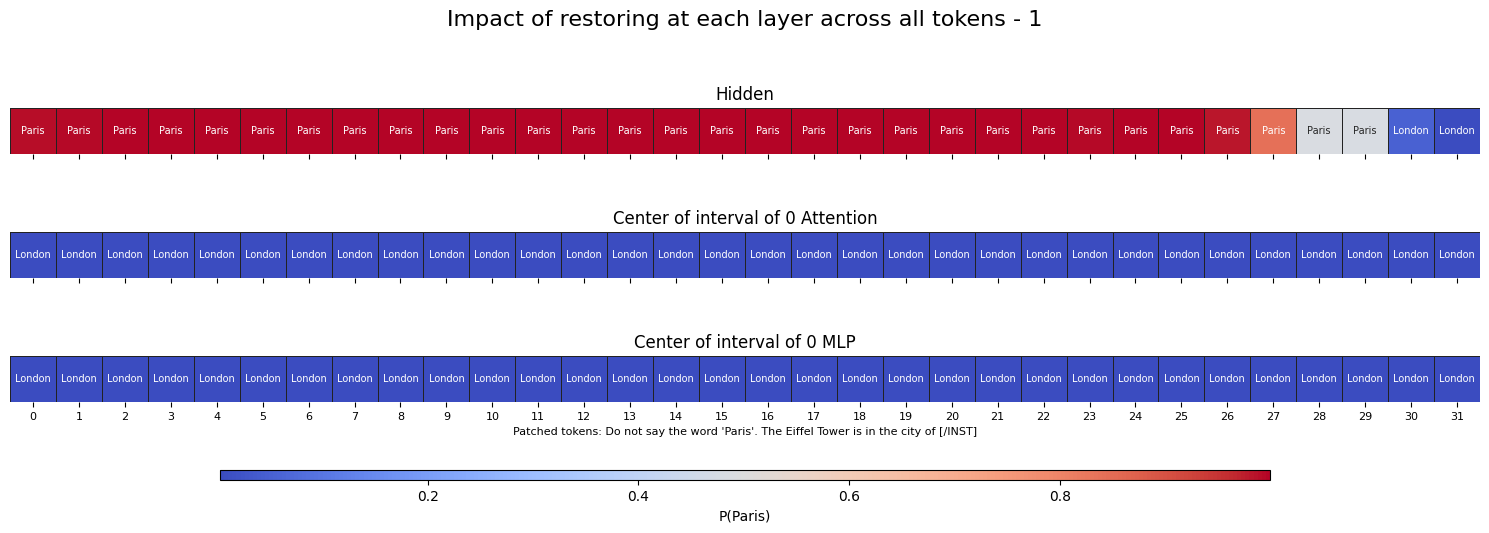

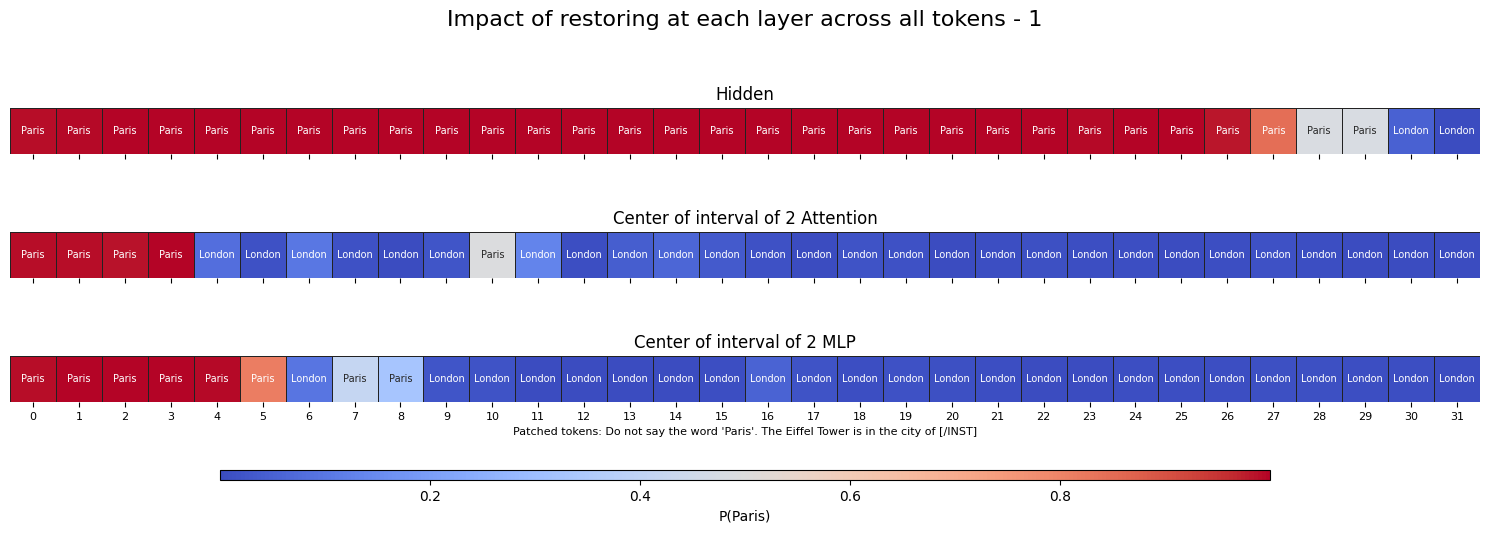

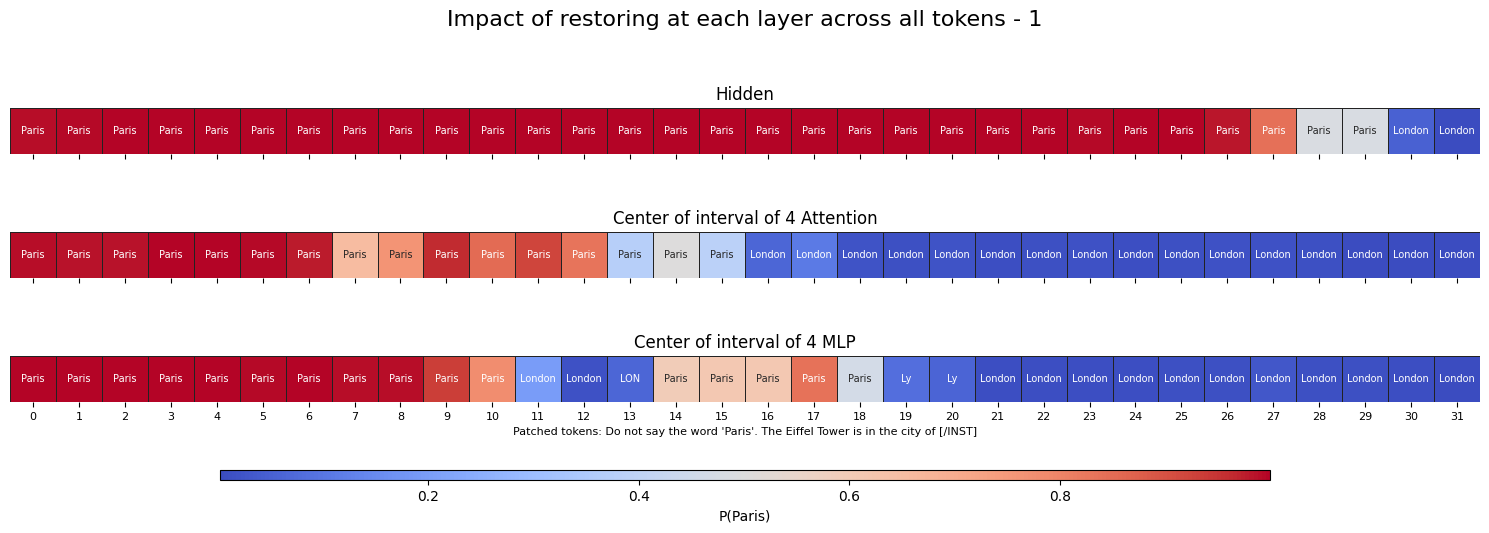

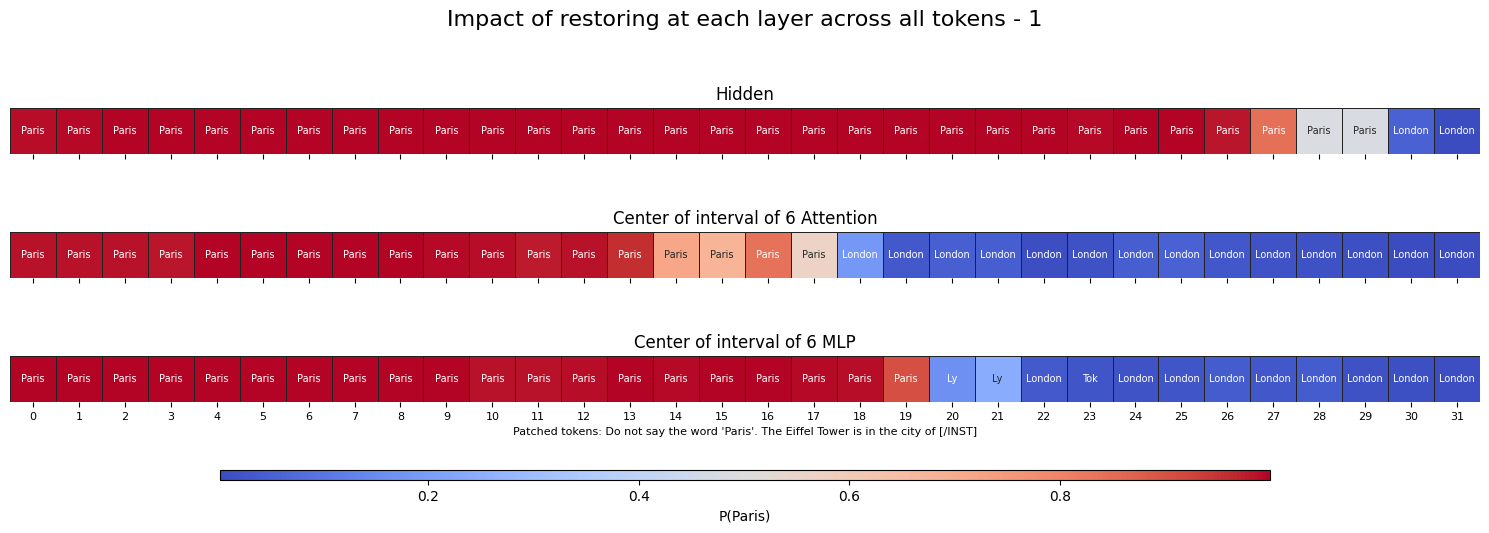

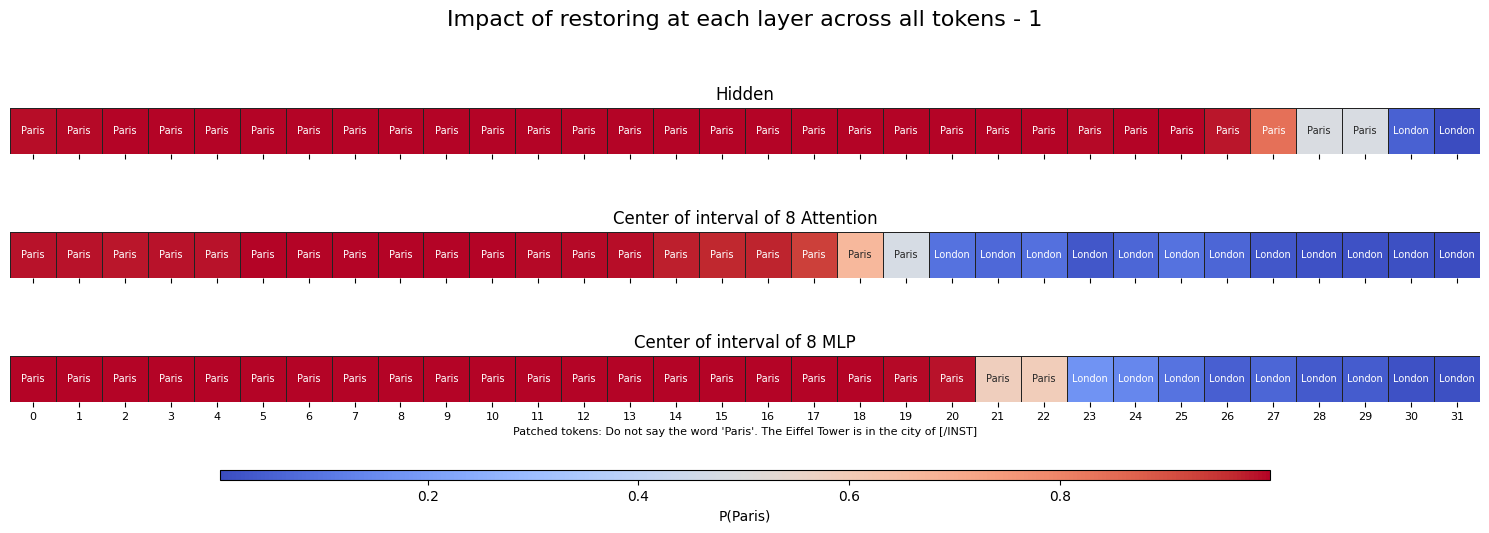

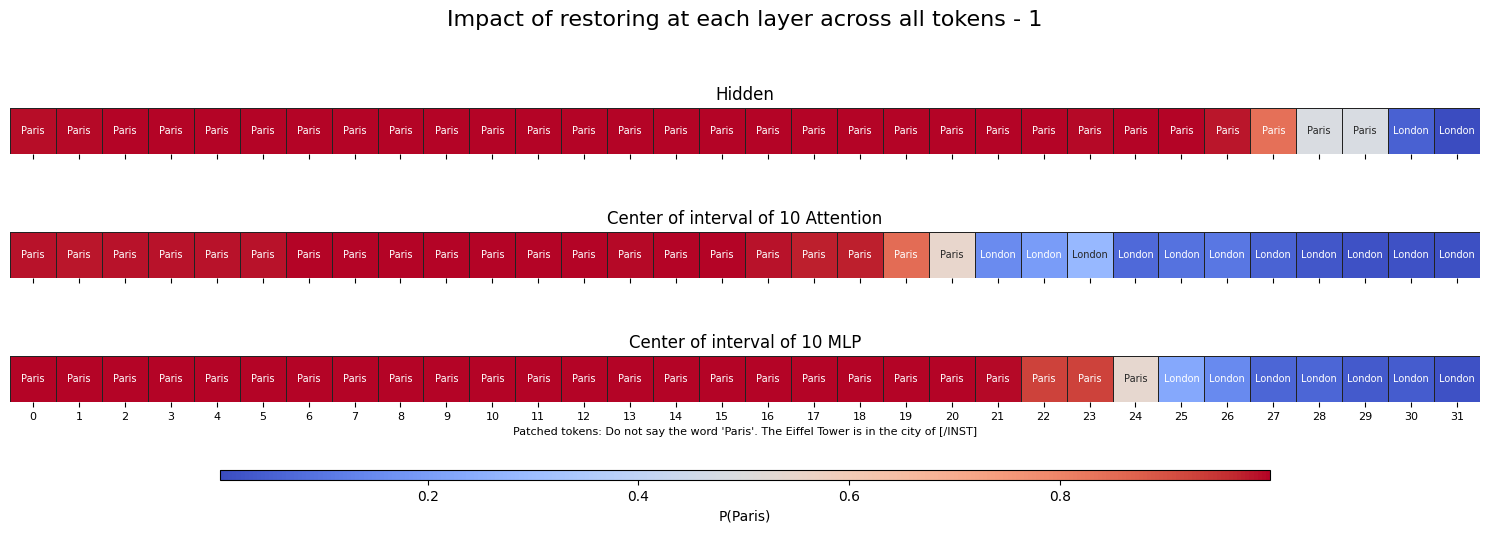

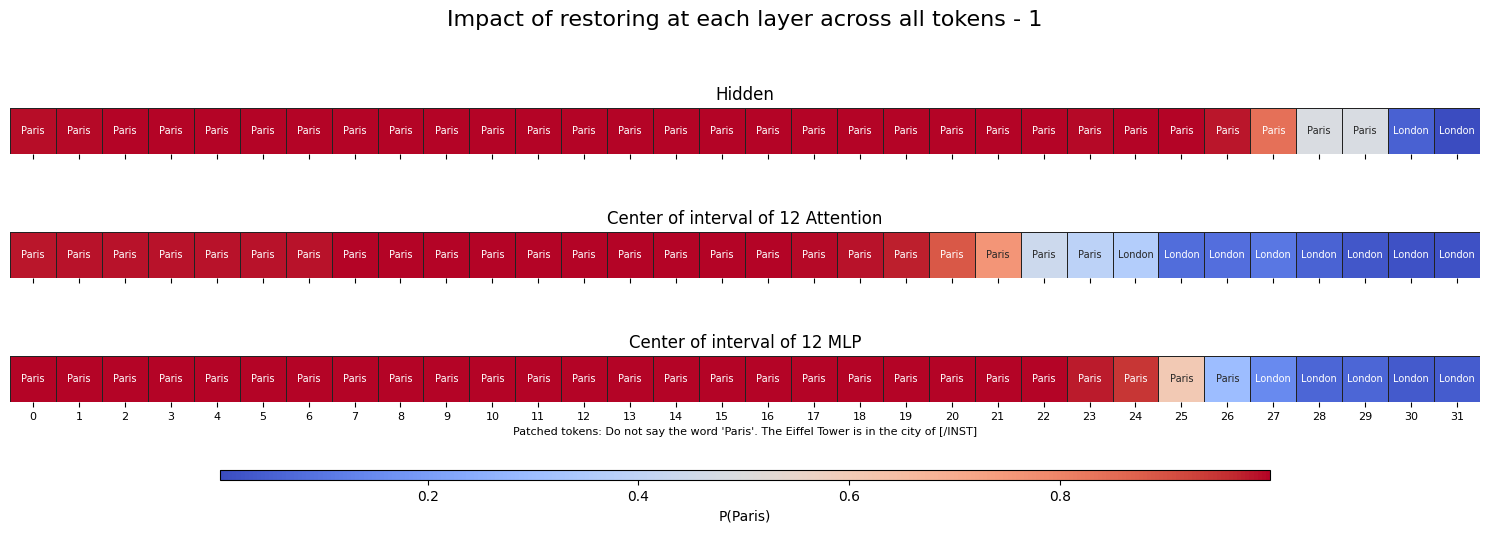

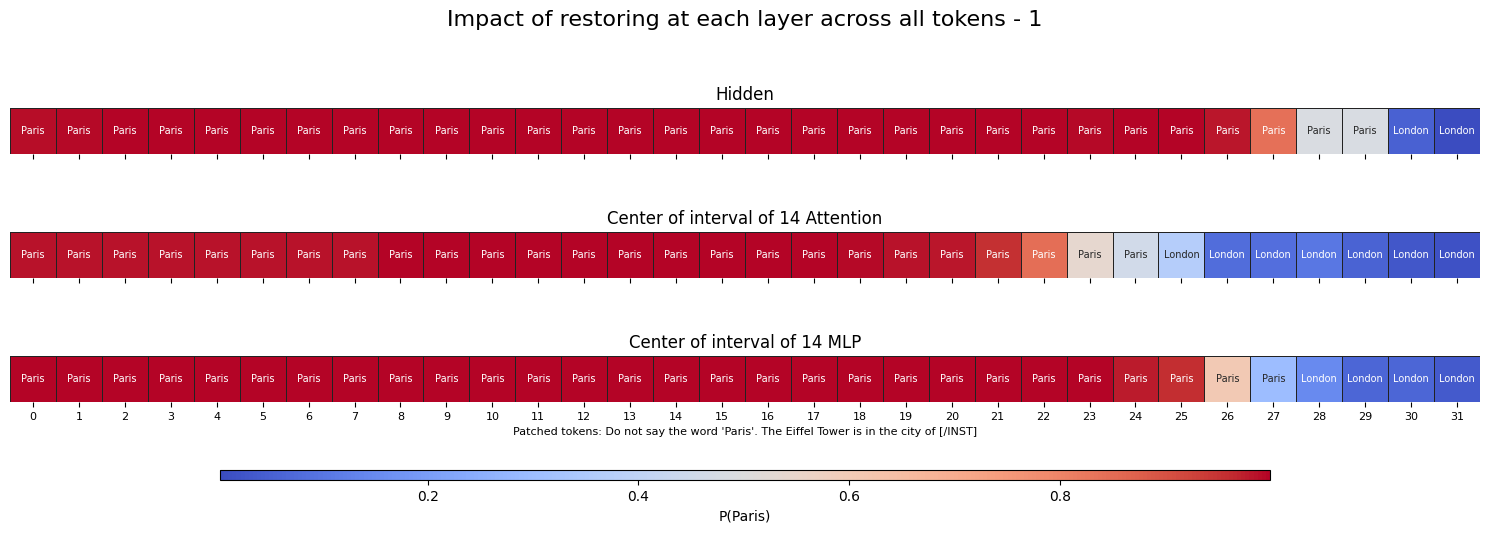

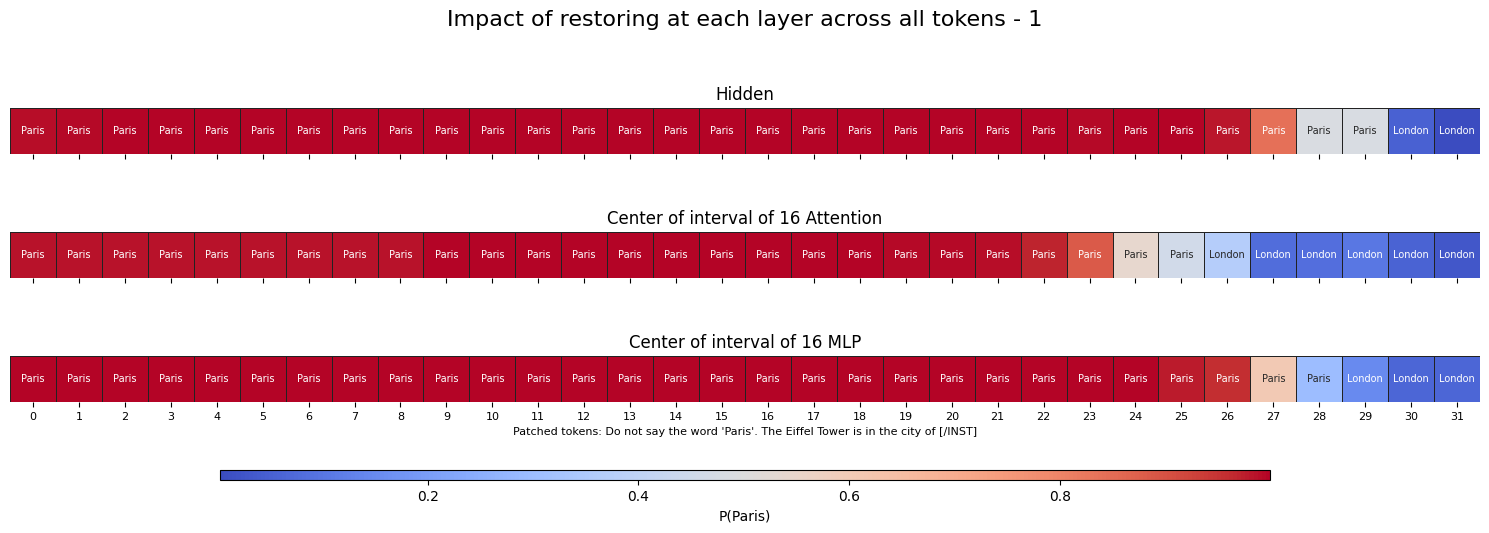

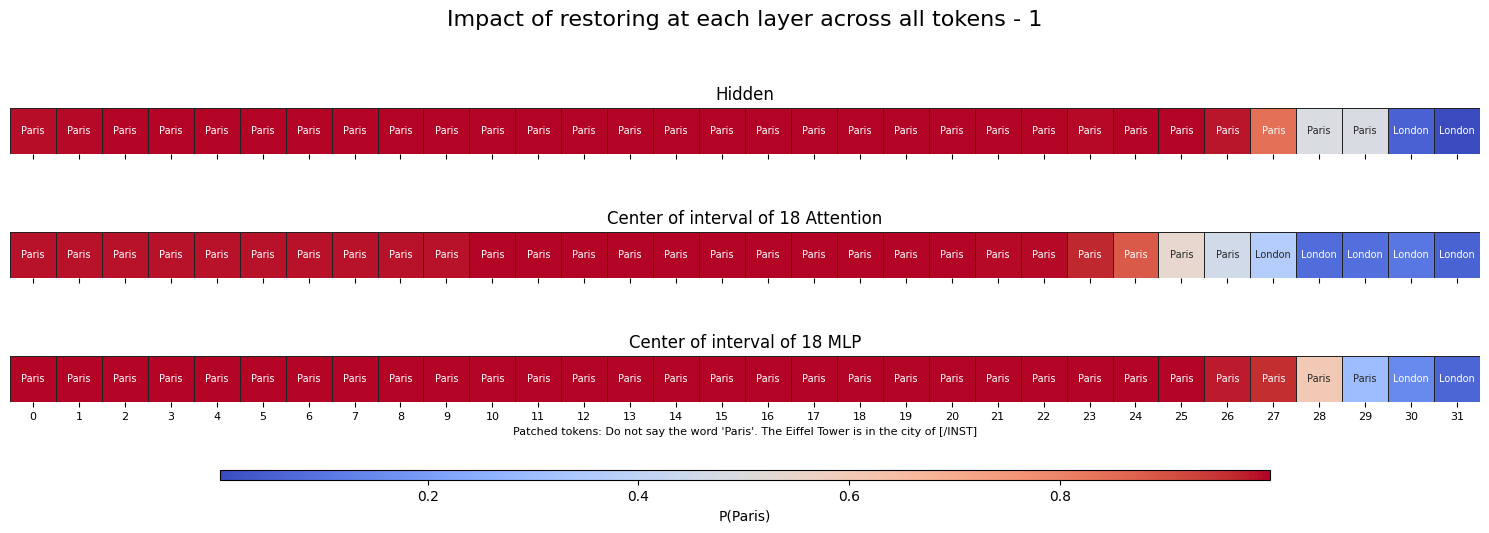

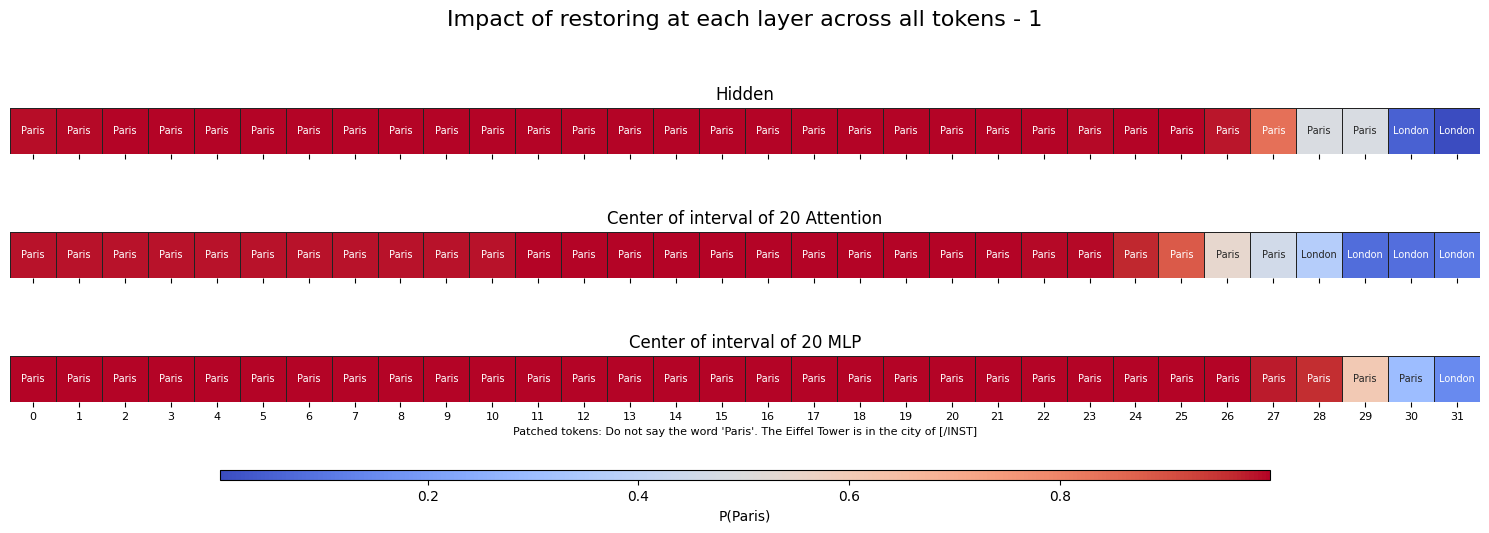

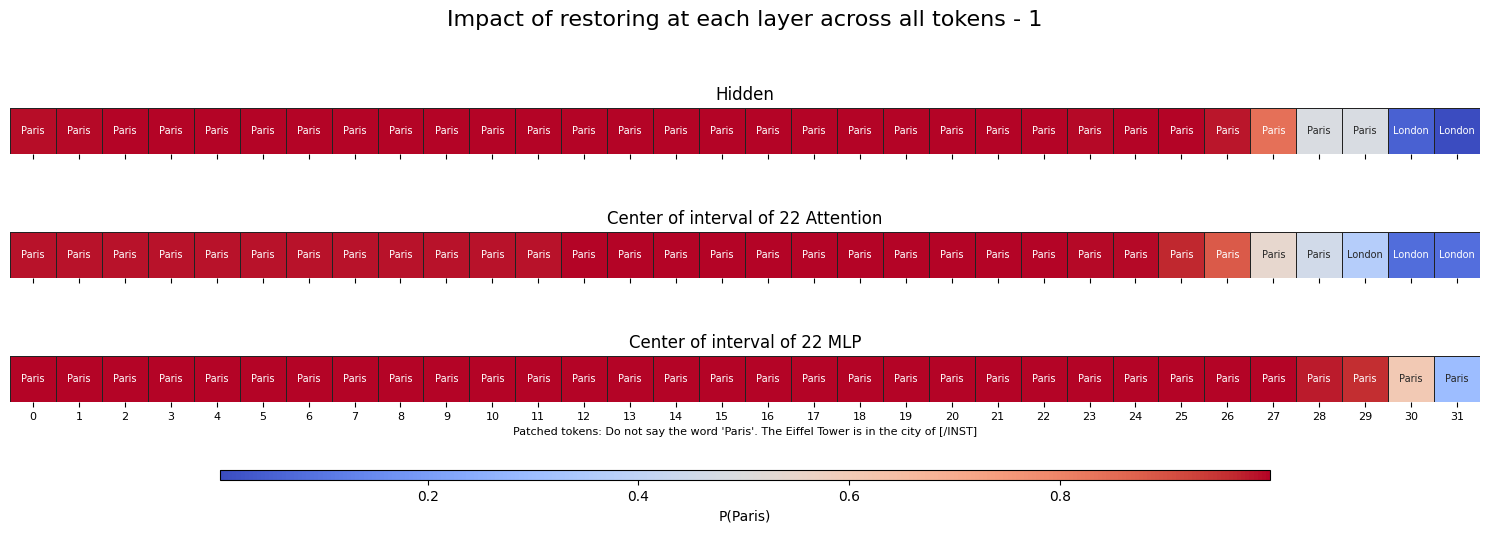

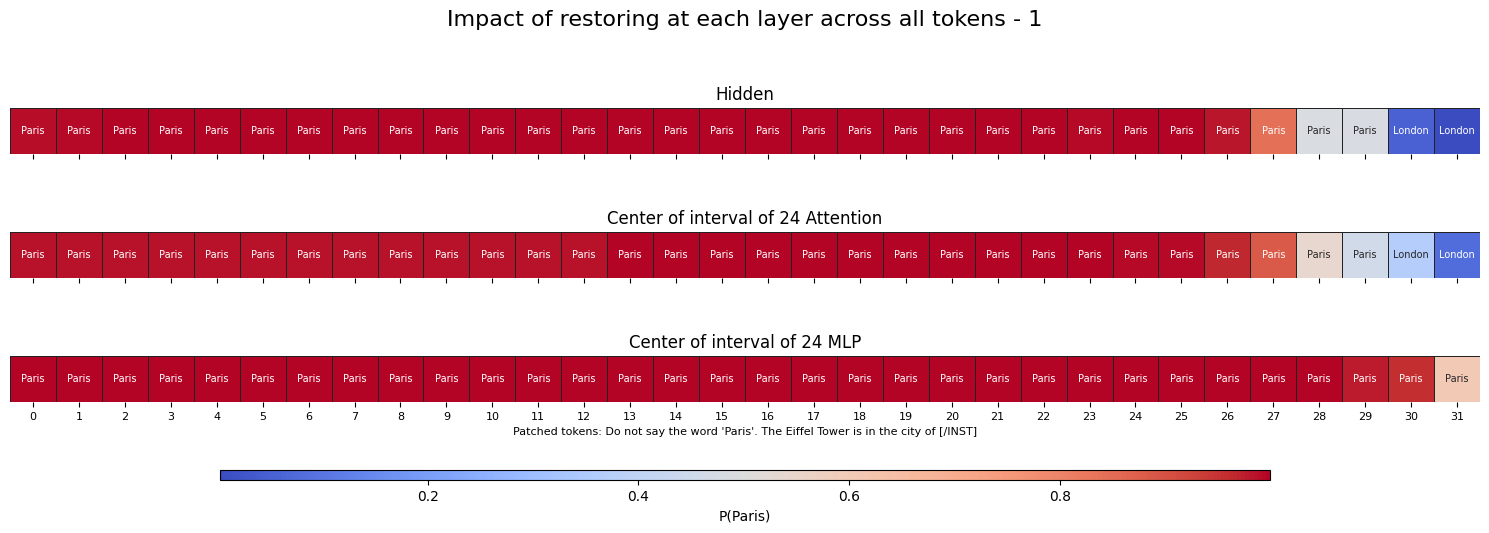

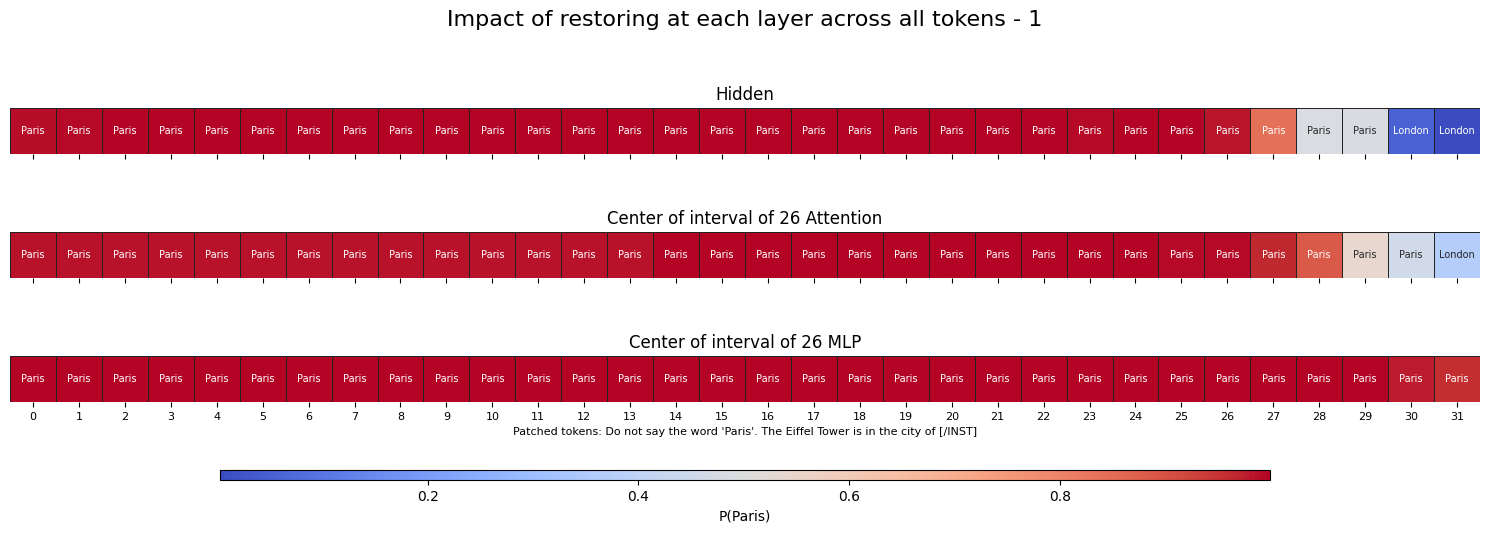

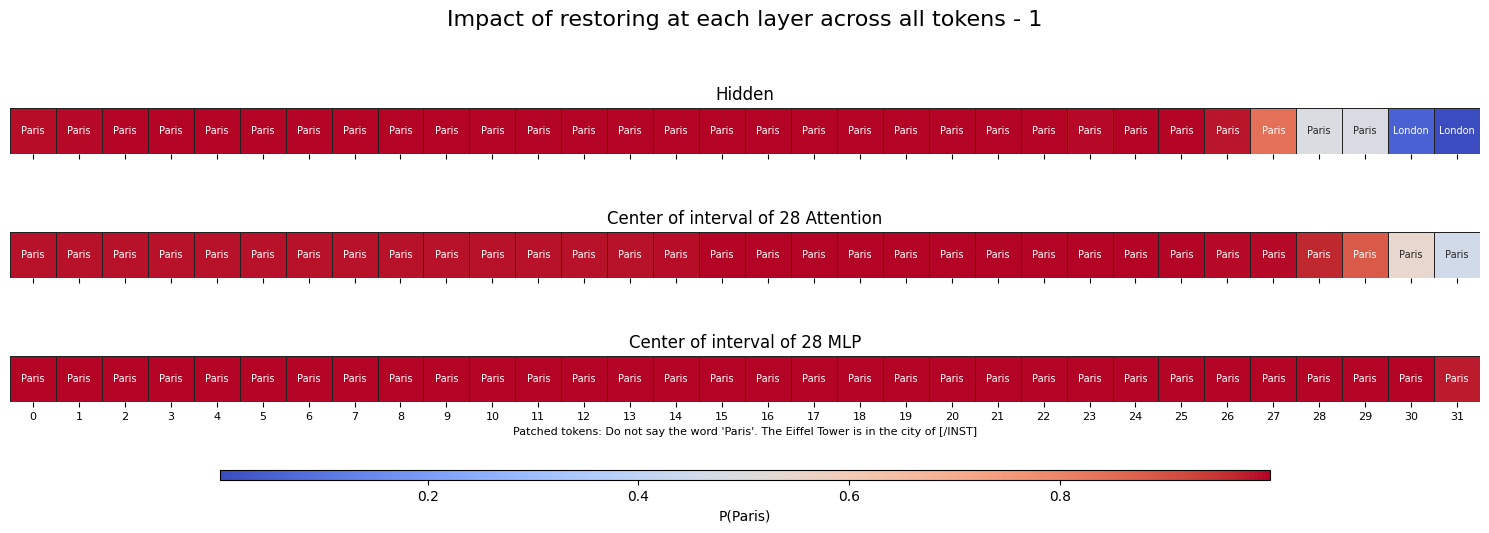

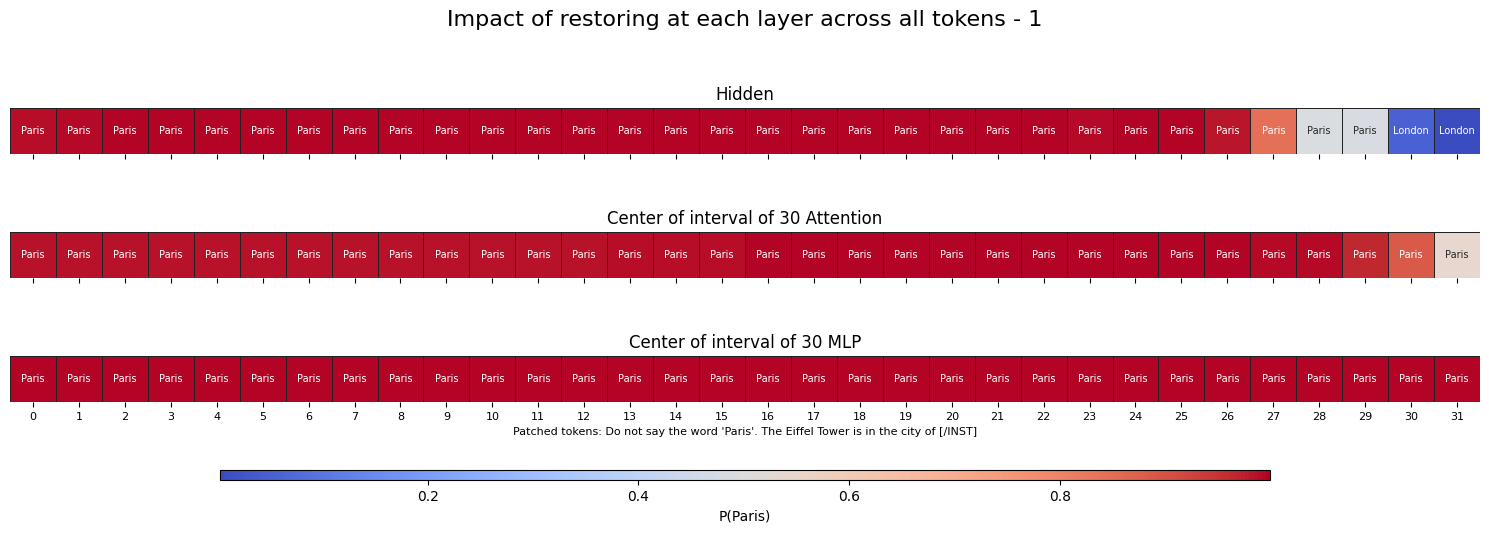

In [38]:
for i in range(0,31,2):
    hidden_scores, attention_scores, mlp_scores = reverse_layer_across_tokens(
        model=model,
        tokenizer=tokenizer,
        setup_tokens=s_tokens,
        defense_tokens=d_tokens,
        query_tokens=q_tokens,
        words_to_check=words_to_check,
        num_layers=num_layers,
        x_tokens=newline_tokens,
        window=i,
    )
    reverse_layer_across_tokens_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5), window = i)

In [ ]:
hidden_scores, attention_scores, mlp_scores = reverse_trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

In [ ]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>\n\n"""
word_of_interest = "India"
d = f"Do not say the word '{word_of_interest}'. "
prompt = "The Taj Mahal is in the country of"
q = f"""\
Respond with one word. {prompt} [/INST]
"""

t = f"""\
H
Respond
H
"""

s_tokens = tokenizer.encode(s)
d_tokens = tokenizer.encode(d)
d_tokens = [6132] + d_tokens[2:len(d_tokens)]
# d_tokens = d_tokens[1:len(d_tokens)]
q_tokens = [1666] + tokenizer.encode(q)[2:]

newline_tokens = tokenizer.encode("\n")[2:] * len(d_tokens)
space_tokens = [29871] * len(d_tokens)
random_sentence_tokens = tokenizer.encode("Peanuts don't grow on trees.")[1:]
period_tokens = tokenizer.encode(".")[1:] * len(d_tokens)

words_to_check=['Ind', 'India', 'IND', 'In', "IN", "india"]

d_prompt = s + d + q
u_prompt = s + q
newline_u_prompt = s + tokenizer.decode(newline_tokens) + q

defended_tokens = s_tokens + d_tokens + q_tokens
undefended_tokens = s_tokens + q_tokens
newline_undefended_tokens = s_tokens + newline_tokens + q_tokens

q_length = len(q_tokens)
dq_length = len(d_tokens) + q_length
num_layers = 32
# prompt = s + q

In [ ]:
hidden_scores, attention_scores, mlp_scores = reverse_trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

In [ ]:
s = f"""\
<<SYS>>
You are a helpful assistant.
<</SYS>>\n\n"""
word_of_interest = "Paris"
d = f"Do not say the word '{word_of_interest}'. "
prompt = "The Eiffel Tower is in the city of"
q = f"""\
Respond with one word. {prompt} [/INST]
"""

t = f"""\
H
Respond
H
"""

s_tokens = tokenizer.encode(s)
d_tokens = tokenizer.encode(d)
d_tokens = [6132] + d_tokens[2:len(d_tokens)]
# d_tokens = d_tokens[1:len(d_tokens)]
q_tokens = [1666] + tokenizer.encode(q)[2:]

newline_tokens = tokenizer.encode("\n")[2:] * len(d_tokens)
space_tokens = [29871] * len(d_tokens)
random_sentence_tokens = tokenizer.encode("Peanuts don't grow on trees.")[1:]
period_tokens = tokenizer.encode(".")[1:] * len(d_tokens)

words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"]

d_prompt = s + d + q
u_prompt = s + q
newline_u_prompt = s + tokenizer.decode(newline_tokens) + q

defended_tokens = s_tokens + d_tokens + q_tokens
undefended_tokens = s_tokens + q_tokens
newline_undefended_tokens = s_tokens + newline_tokens + q_tokens

q_length = len(q_tokens)
dq_length = len(d_tokens) + q_length
num_layers = 32
# prompt = s + q

In [ ]:
hidden_scores, attention_scores, mlp_scores = reverse_trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

# Plotting all heatmaps

In [ ]:
plot_all_flow(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    word_of_interest=word_of_interest,
    x_list=[newline_tokens],
)

# Testing everything

In [ ]:
plot_all_flow(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    word_of_interest=word_of_interest,
    x_list=[newline_tokens],
)

In [ ]:
hidden_scores, attention_scores, mlp_scores = trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)

In [ ]:
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

In [ ]:
reverse_plot_all_flow(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    word_of_interest=word_of_interest,
    x_list=[newline_tokens],
)

In [ ]:
hidden_scores, attention_scores, mlp_scores = reverse_trace_token_across_all_layers_separate(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    x_tokens=newline_tokens,
)
all_layers_heatmaps(hidden_scores, attention_scores, mlp_scores, d_tokens + q_tokens, word_of_interest, figsize=(15, 5))

# Individual Heatmaps & Old Testing

## Generating Tracing Maps

In [ ]:
scores, next_tokens = trace_all_hidden_states(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
)

In [ ]:
create_heatmap(list(map(list, zip(*scores))), list(map(list, zip(*next_tokens))), num_layers, q_length, 'Impact of Restoring Q Hidden States from Defended to Undefended', 'P(Paris)', q_tokens, tokenizer=tokenizer)


In [ ]:
attn_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    kind='attn',
)


In [ ]:
create_heatmap(list(map(list, zip(*attn_scores))), num_layers, q_length, 'Impact of Restoring Attention from Defended to Undefended', 'P(Paris)', q_tokens, tokenizer=tokenizer, kind='attn')

In [ ]:
mlp_scores, mlp_preds = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=words_to_check,
    num_layers=num_layers,
    kind='mlp',
    x_tokens=newline_tokens,
)


In [ ]:
create_heatmap(mlp_scores, mlp_preds, num_layers, dq_length, 'Impact of Restoring MLP from Defended to Undefended', 'P(Paris)', d_tokens + q_tokens, tokenizer=tokenizer, kind='mlp')

## X Prompt & Testing

In [ ]:
token_list = ['Par', 'PAR', 'Paris', 'P', "par"]
tokens, probs = get_token_probabilities(model, tokenizer, s_tokens + space_tokens + q_tokens, token_list)
for token, prob in zip(tokens, probs):
    print(f"Token: {token}, Probability: {prob}")
print(sum(probs))

In [ ]:
space_tokens = tokenizer.encode("\n")[2:] * len(d_tokens)
print(space_tokens)
trace_with_patch(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    # states_to_patch_query = [(t, f"model.layers.{layer_num}") for layer_num in range(num_layers) for t in range(dq_length)],
    # states_to_patch_query = [(t, f"model.layers.{12}") for t in range(8)],
    states_to_patch_query=[],
    x_tokens=space_tokens,
)


## X Heatmaps

In [ ]:
space_tokens = tokenizer.encode("\n")[2:] * 10
print(space_tokens)
n_x_scores = trace_all_hidden_states(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    x_tokens=space_tokens,
)

In [ ]:
create_heatmap(n_x_scores, num_layers, dq_length, 'Impact of Restoring X & Q Hidden States from Defended to Undefended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer)

In [ ]:
x_attn_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    kind="attn",
    x_tokens=space_tokens,
)

In [ ]:
create_heatmap(list(map(list, zip(*x_attn_scores))), num_layers, dq_length, 'Impact of Restoring X & Q Attention from Defended to Undefended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer, kind='attn')

In [ ]:
x_mlp_scores = trace_important_window(
    model=model,
    tokenizer=tokenizer,
    setup_tokens=s_tokens,
    defense_tokens=d_tokens,
    query_tokens=q_tokens,
    words_to_check=['Par', 'PAR', 'Paris', 'P', "par", "paris"],
    num_layers=num_layers,
    kind="mlp",
    x_tokens=space_tokens,
)

In [ ]:
create_heatmap(list(map(list, zip(*x_mlp_scores))), num_layers, dq_length, 'Impact of Restoring X & Q MLP from Defended to Undefended', 'P(Paris)', patched_tokens=d_tokens + q_tokens, tokenizer=tokenizer, kind='mlp')